In [1]:
import sys
# sys.path.insert(0, '../../Utilities/')
from mpl_toolkits import mplot3d
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import h5py

In [2]:


class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star




In [3]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\COMPOSITE NEW_.csv")

q_z= df.loc[:,["Directional Heat Flux (Z)" ]] 

q_z_new=np.array(q_z)

q_z_new_sq=np.square(q_z_new)

q_x= df.loc[:,["Directional Heat Flux (X)" ]] 

q_x_new=np.array(q_x)

q_x_new_sq=np.square(q_x_new)

q_final = np.sqrt((q_x_new_sq+q_z_new_sq))

x_y=df.loc[:,["X Location (m)","Z Location (m)" ]] 

x_y=np.array(x_y)

u=df.loc[:,"Temperature (K)"]

u=np.array(u)

u=u.reshape(38445,1)

N_u_1=3000
layers1 = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

lb1 = x_y.min(0)
ub1 = x_y.max(0)

idx = np.random.choice(x_y.shape[0], N_u_1, replace=False)
X_u_train = x_y[idx,:]
u_train = u[idx,:]
# q = scaled_q[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)
# q_= tf.convert_to_tensor(q,dtype=tf.float32)

In [4]:

model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 2.716e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.71
It: 10, Loss: 2.128e+00, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.12
It: 20, Loss: 1.720e+00, Lambda_1: 0.018, Lambda_2: 1.000000, Time: 0.12
It: 30, Loss: 1.478e+00, Lambda_1: 0.029, Lambda_2: 1.000000, Time: 0.11
It: 40, Loss: 1.361e+00, Lambda_1: 0.041, Lambda_2: 1.000000, Time: 0.12
It: 50, Loss: 1.321e+00, Lambda_1: 0.055, Lambda_2: 1.000000, Time: 0.11
It: 60, Loss: 1.313e+00, Lambda_1: 0.069, Lambda_2: 1.000000, Time: 0.16
It: 70, Loss: 1.313e+00, Lambda_1: 0.083, Lambda_2: 1.000000, Time: 0.12
It: 80, Loss: 1.313e+00, Lambda_1: 0

It: 1070, Loss: 2.945e-01, Lambda_1: 1.907, Lambda_2: 1.000000, Time: 0.13
It: 1080, Loss: 2.906e-01, Lambda_1: 1.909, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 2.869e-01, Lambda_1: 1.911, Lambda_2: 1.000000, Time: 0.11
It: 1100, Loss: 2.831e-01, Lambda_1: 1.914, Lambda_2: 1.000000, Time: 0.10
It: 1110, Loss: 2.797e-01, Lambda_1: 1.916, Lambda_2: 1.000000, Time: 0.10
It: 1120, Loss: 2.761e-01, Lambda_1: 1.919, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 2.725e-01, Lambda_1: 1.922, Lambda_2: 1.000000, Time: 0.10
It: 1140, Loss: 2.689e-01, Lambda_1: 1.925, Lambda_2: 1.000000, Time: 0.10
It: 1150, Loss: 2.652e-01, Lambda_1: 1.928, Lambda_2: 1.000000, Time: 0.12
It: 1160, Loss: 2.617e-01, Lambda_1: 1.931, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 2.581e-01, Lambda_1: 1.935, Lambda_2: 1.000000, Time: 0.11
It: 1180, Loss: 2.548e-01, Lambda_1: 1.938, Lambda_2: 1.000000, Time: 0.11
It: 1190, Loss: 2.516e-01, Lambda_1: 1.941, Lambda_2: 1.000000, Time: 0.10
It: 1200, Loss: 2.486e-01

It: 2170, Loss: 1.588e-01, Lambda_1: 2.058, Lambda_2: 1.000000, Time: 0.12
It: 2180, Loss: 1.588e-01, Lambda_1: 2.057, Lambda_2: 1.000000, Time: 0.09
It: 2190, Loss: 1.585e-01, Lambda_1: 2.057, Lambda_2: 1.000000, Time: 0.10
It: 2200, Loss: 1.583e-01, Lambda_1: 2.056, Lambda_2: 1.000000, Time: 0.11
It: 2210, Loss: 1.580e-01, Lambda_1: 2.056, Lambda_2: 1.000000, Time: 0.11
It: 2220, Loss: 1.579e-01, Lambda_1: 2.055, Lambda_2: 1.000000, Time: 0.11
It: 2230, Loss: 1.577e-01, Lambda_1: 2.055, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 1.575e-01, Lambda_1: 2.054, Lambda_2: 1.000000, Time: 0.09
It: 2250, Loss: 1.573e-01, Lambda_1: 2.054, Lambda_2: 1.000000, Time: 0.10
It: 2260, Loss: 1.572e-01, Lambda_1: 2.053, Lambda_2: 1.000000, Time: 0.10
It: 2270, Loss: 1.570e-01, Lambda_1: 2.053, Lambda_2: 1.000000, Time: 0.09
It: 2280, Loss: 1.568e-01, Lambda_1: 2.052, Lambda_2: 1.000000, Time: 0.10
It: 2290, Loss: 1.567e-01, Lambda_1: 2.052, Lambda_2: 1.000000, Time: 0.10
It: 2300, Loss: 1.565e-01

It: 3270, Loss: 1.480e-01, Lambda_1: 1.980, Lambda_2: 1.000000, Time: 0.13
It: 3280, Loss: 1.459e-01, Lambda_1: 1.979, Lambda_2: 1.000000, Time: 0.10
It: 3290, Loss: 1.460e-01, Lambda_1: 1.978, Lambda_2: 1.000000, Time: 0.11
It: 3300, Loss: 1.458e-01, Lambda_1: 1.977, Lambda_2: 1.000000, Time: 0.12
It: 3310, Loss: 1.457e-01, Lambda_1: 1.976, Lambda_2: 1.000000, Time: 0.12
It: 3320, Loss: 1.456e-01, Lambda_1: 1.974, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 1.456e-01, Lambda_1: 1.973, Lambda_2: 1.000000, Time: 0.12
It: 3340, Loss: 1.455e-01, Lambda_1: 1.972, Lambda_2: 1.000000, Time: 0.10
It: 3350, Loss: 1.454e-01, Lambda_1: 1.971, Lambda_2: 1.000000, Time: 0.13
It: 3360, Loss: 1.454e-01, Lambda_1: 1.970, Lambda_2: 1.000000, Time: 0.10
It: 3370, Loss: 1.453e-01, Lambda_1: 1.969, Lambda_2: 1.000000, Time: 0.11
It: 3380, Loss: 1.452e-01, Lambda_1: 1.968, Lambda_2: 1.000000, Time: 0.11
It: 3390, Loss: 1.452e-01, Lambda_1: 1.967, Lambda_2: 1.000000, Time: 0.12
It: 3400, Loss: 1.453e-01

It: 4370, Loss: 1.401e-01, Lambda_1: 1.855, Lambda_2: 1.000000, Time: 0.11
It: 4380, Loss: 1.401e-01, Lambda_1: 1.854, Lambda_2: 1.000000, Time: 0.10
It: 4390, Loss: 1.400e-01, Lambda_1: 1.853, Lambda_2: 1.000000, Time: 0.12
It: 4400, Loss: 1.400e-01, Lambda_1: 1.852, Lambda_2: 1.000000, Time: 0.11
It: 4410, Loss: 1.440e-01, Lambda_1: 1.851, Lambda_2: 1.000000, Time: 0.12
It: 4420, Loss: 1.399e-01, Lambda_1: 1.850, Lambda_2: 1.000000, Time: 0.11
It: 4430, Loss: 1.402e-01, Lambda_1: 1.848, Lambda_2: 1.000000, Time: 0.11
It: 4440, Loss: 1.400e-01, Lambda_1: 1.847, Lambda_2: 1.000000, Time: 0.10
It: 4450, Loss: 1.398e-01, Lambda_1: 1.846, Lambda_2: 1.000000, Time: 0.13
It: 4460, Loss: 1.397e-01, Lambda_1: 1.846, Lambda_2: 1.000000, Time: 0.10
It: 4470, Loss: 1.397e-01, Lambda_1: 1.845, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 1.397e-01, Lambda_1: 1.844, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 1.396e-01, Lambda_1: 1.843, Lambda_2: 1.000000, Time: 0.11
It: 4500, Loss: 1.396e-01

It: 5470, Loss: 1.359e-01, Lambda_1: 1.781, Lambda_2: 1.000000, Time: 0.12
It: 5480, Loss: 1.359e-01, Lambda_1: 1.781, Lambda_2: 1.000000, Time: 0.11
It: 5490, Loss: 1.358e-01, Lambda_1: 1.780, Lambda_2: 1.000000, Time: 0.12
It: 5500, Loss: 1.360e-01, Lambda_1: 1.780, Lambda_2: 1.000000, Time: 0.11
It: 5510, Loss: 1.369e-01, Lambda_1: 1.780, Lambda_2: 1.000000, Time: 0.10
It: 5520, Loss: 1.359e-01, Lambda_1: 1.779, Lambda_2: 1.000000, Time: 0.10
It: 5530, Loss: 1.356e-01, Lambda_1: 1.779, Lambda_2: 1.000000, Time: 0.11
It: 5540, Loss: 1.357e-01, Lambda_1: 1.779, Lambda_2: 1.000000, Time: 0.11
It: 5550, Loss: 1.356e-01, Lambda_1: 1.778, Lambda_2: 1.000000, Time: 0.12
It: 5560, Loss: 1.355e-01, Lambda_1: 1.778, Lambda_2: 1.000000, Time: 0.11
It: 5570, Loss: 1.355e-01, Lambda_1: 1.778, Lambda_2: 1.000000, Time: 0.13
It: 5580, Loss: 1.364e-01, Lambda_1: 1.778, Lambda_2: 1.000000, Time: 0.10
It: 5590, Loss: 1.355e-01, Lambda_1: 1.777, Lambda_2: 1.000000, Time: 0.12
It: 5600, Loss: 1.356e-01

It: 6570, Loss: 1.303e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6580, Loss: 1.307e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.10
It: 6590, Loss: 1.300e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.11
It: 6600, Loss: 1.300e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.10
It: 6610, Loss: 1.297e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6620, Loss: 1.297e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6630, Loss: 1.298e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 1.311e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.10
It: 6650, Loss: 1.304e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.11
It: 6660, Loss: 1.297e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.11
It: 6670, Loss: 1.295e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6680, Loss: 1.293e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.11
It: 6690, Loss: 1.292e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.12
It: 6700, Loss: 1.292e-01

It: 7670, Loss: 1.258e-01, Lambda_1: 1.758, Lambda_2: 1.000000, Time: 0.13
It: 7680, Loss: 1.225e-01, Lambda_1: 1.757, Lambda_2: 1.000000, Time: 0.10
It: 7690, Loss: 1.202e-01, Lambda_1: 1.756, Lambda_2: 1.000000, Time: 0.11
It: 7700, Loss: 1.201e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 7710, Loss: 1.200e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.12
It: 7720, Loss: 1.198e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.11
It: 7730, Loss: 1.196e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.12
It: 7740, Loss: 1.195e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.11
It: 7750, Loss: 1.194e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.12
It: 7760, Loss: 1.199e-01, Lambda_1: 1.753, Lambda_2: 1.000000, Time: 0.10
It: 7770, Loss: 1.200e-01, Lambda_1: 1.753, Lambda_2: 1.000000, Time: 0.11
It: 7780, Loss: 1.202e-01, Lambda_1: 1.752, Lambda_2: 1.000000, Time: 0.11
It: 7790, Loss: 1.195e-01, Lambda_1: 1.752, Lambda_2: 1.000000, Time: 0.12
It: 7800, Loss: 1.187e-01

It: 8780, Loss: 1.064e-01, Lambda_1: 1.660, Lambda_2: 1.000000, Time: 0.12
It: 8790, Loss: 1.065e-01, Lambda_1: 1.659, Lambda_2: 1.000000, Time: 0.11
It: 8800, Loss: 1.064e-01, Lambda_1: 1.658, Lambda_2: 1.000000, Time: 0.11
It: 8810, Loss: 1.062e-01, Lambda_1: 1.656, Lambda_2: 1.000000, Time: 0.10
It: 8820, Loss: 1.061e-01, Lambda_1: 1.655, Lambda_2: 1.000000, Time: 0.11
It: 8830, Loss: 1.069e-01, Lambda_1: 1.654, Lambda_2: 1.000000, Time: 0.10
It: 8840, Loss: 1.067e-01, Lambda_1: 1.653, Lambda_2: 1.000000, Time: 0.13
It: 8850, Loss: 1.070e-01, Lambda_1: 1.651, Lambda_2: 1.000000, Time: 0.11
It: 8860, Loss: 1.058e-01, Lambda_1: 1.650, Lambda_2: 1.000000, Time: 0.12
It: 8870, Loss: 1.065e-01, Lambda_1: 1.649, Lambda_2: 1.000000, Time: 0.11
It: 8880, Loss: 1.057e-01, Lambda_1: 1.647, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 1.062e-01, Lambda_1: 1.646, Lambda_2: 1.000000, Time: 0.11
It: 8900, Loss: 1.060e-01, Lambda_1: 1.645, Lambda_2: 1.000000, Time: 0.11
It: 8910, Loss: 1.057e-01

It: 9890, Loss: 1.010e-01, Lambda_1: 1.525, Lambda_2: 1.000000, Time: 0.13
It: 9900, Loss: 1.002e-01, Lambda_1: 1.524, Lambda_2: 1.000000, Time: 0.11
It: 9910, Loss: 1.001e-01, Lambda_1: 1.523, Lambda_2: 1.000000, Time: 0.13
It: 9920, Loss: 1.016e-01, Lambda_1: 1.522, Lambda_2: 1.000000, Time: 0.10
It: 9930, Loss: 1.001e-01, Lambda_1: 1.521, Lambda_2: 1.000000, Time: 0.11
It: 9940, Loss: 1.015e-01, Lambda_1: 1.520, Lambda_2: 1.000000, Time: 0.11
It: 9950, Loss: 1.003e-01, Lambda_1: 1.519, Lambda_2: 1.000000, Time: 0.12
It: 9960, Loss: 1.000e-01, Lambda_1: 1.518, Lambda_2: 1.000000, Time: 0.11
It: 9970, Loss: 1.004e-01, Lambda_1: 1.517, Lambda_2: 1.000000, Time: 0.13
It: 9980, Loss: 9.987e-02, Lambda_1: 1.516, Lambda_2: 1.000000, Time: 0.11
It: 9990, Loss: 9.971e-02, Lambda_1: 1.515, Lambda_2: 1.000000, Time: 0.11
It: 10000, Loss: 1.001e-01, Lambda_1: 1.514, Lambda_2: 1.000000, Time: 0.10
It: 10010, Loss: 1.018e-01, Lambda_1: 1.513, Lambda_2: 1.000000, Time: 0.12
It: 10020, Loss: 1.004e

It: 10980, Loss: 9.005e-02, Lambda_1: 1.355, Lambda_2: 1.000000, Time: 0.12
It: 10990, Loss: 9.060e-02, Lambda_1: 1.352, Lambda_2: 1.000000, Time: 0.11
It: 11000, Loss: 9.165e-02, Lambda_1: 1.349, Lambda_2: 1.000000, Time: 0.13
It: 11010, Loss: 9.015e-02, Lambda_1: 1.346, Lambda_2: 1.000000, Time: 0.10
It: 11020, Loss: 9.036e-02, Lambda_1: 1.344, Lambda_2: 1.000000, Time: 0.11
It: 11030, Loss: 8.973e-02, Lambda_1: 1.341, Lambda_2: 1.000000, Time: 0.11
It: 11040, Loss: 8.984e-02, Lambda_1: 1.339, Lambda_2: 1.000000, Time: 0.11
It: 11050, Loss: 9.125e-02, Lambda_1: 1.336, Lambda_2: 1.000000, Time: 0.11
It: 11060, Loss: 8.983e-02, Lambda_1: 1.334, Lambda_2: 1.000000, Time: 0.13
It: 11070, Loss: 8.994e-02, Lambda_1: 1.331, Lambda_2: 1.000000, Time: 0.12
It: 11080, Loss: 9.016e-02, Lambda_1: 1.329, Lambda_2: 1.000000, Time: 0.12
It: 11090, Loss: 8.961e-02, Lambda_1: 1.326, Lambda_2: 1.000000, Time: 0.11
It: 11100, Loss: 8.954e-02, Lambda_1: 1.324, Lambda_2: 1.000000, Time: 0.13
It: 11110, L

It: 12070, Loss: 8.253e-02, Lambda_1: 1.161, Lambda_2: 1.000000, Time: 0.13
It: 12080, Loss: 8.199e-02, Lambda_1: 1.159, Lambda_2: 1.000000, Time: 0.12
It: 12090, Loss: 8.194e-02, Lambda_1: 1.158, Lambda_2: 1.000000, Time: 0.12
It: 12100, Loss: 8.332e-02, Lambda_1: 1.156, Lambda_2: 1.000000, Time: 0.11
It: 12110, Loss: 8.215e-02, Lambda_1: 1.155, Lambda_2: 1.000000, Time: 0.12
It: 12120, Loss: 8.284e-02, Lambda_1: 1.153, Lambda_2: 1.000000, Time: 0.11
It: 12130, Loss: 8.149e-02, Lambda_1: 1.152, Lambda_2: 1.000000, Time: 0.13
It: 12140, Loss: 8.180e-02, Lambda_1: 1.150, Lambda_2: 1.000000, Time: 0.11
It: 12150, Loss: 8.179e-02, Lambda_1: 1.149, Lambda_2: 1.000000, Time: 0.13
It: 12160, Loss: 8.182e-02, Lambda_1: 1.147, Lambda_2: 1.000000, Time: 0.10
It: 12170, Loss: 8.199e-02, Lambda_1: 1.146, Lambda_2: 1.000000, Time: 0.11
It: 12180, Loss: 8.159e-02, Lambda_1: 1.145, Lambda_2: 1.000000, Time: 0.10
It: 12190, Loss: 8.127e-02, Lambda_1: 1.143, Lambda_2: 1.000000, Time: 0.12
It: 12200, L

It: 13150, Loss: 7.602e-02, Lambda_1: 1.048, Lambda_2: 1.000000, Time: 0.11
It: 13160, Loss: 7.503e-02, Lambda_1: 1.047, Lambda_2: 1.000000, Time: 0.11
It: 13170, Loss: 7.508e-02, Lambda_1: 1.047, Lambda_2: 1.000000, Time: 0.12
It: 13180, Loss: 7.673e-02, Lambda_1: 1.046, Lambda_2: 1.000000, Time: 0.11
It: 13190, Loss: 7.537e-02, Lambda_1: 1.045, Lambda_2: 1.000000, Time: 0.13
It: 13200, Loss: 7.592e-02, Lambda_1: 1.045, Lambda_2: 1.000000, Time: 0.10
It: 13210, Loss: 7.489e-02, Lambda_1: 1.044, Lambda_2: 1.000000, Time: 0.11
It: 13220, Loss: 7.479e-02, Lambda_1: 1.043, Lambda_2: 1.000000, Time: 0.10
It: 13230, Loss: 7.541e-02, Lambda_1: 1.043, Lambda_2: 1.000000, Time: 0.11
It: 13240, Loss: 7.662e-02, Lambda_1: 1.043, Lambda_2: 1.000000, Time: 0.11
It: 13250, Loss: 7.460e-02, Lambda_1: 1.042, Lambda_2: 1.000000, Time: 0.11
It: 13260, Loss: 7.533e-02, Lambda_1: 1.041, Lambda_2: 1.000000, Time: 0.11
It: 13270, Loss: 7.540e-02, Lambda_1: 1.041, Lambda_2: 1.000000, Time: 0.13
It: 13280, L

It: 14230, Loss: 7.022e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 14240, Loss: 7.330e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.11
It: 14250, Loss: 7.004e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.13
It: 14260, Loss: 7.142e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.12
It: 14270, Loss: 7.025e-02, Lambda_1: 0.996, Lambda_2: 1.000000, Time: 0.13
It: 14280, Loss: 7.046e-02, Lambda_1: 0.996, Lambda_2: 1.000000, Time: 0.10
It: 14290, Loss: 7.008e-02, Lambda_1: 0.996, Lambda_2: 1.000000, Time: 0.11
It: 14300, Loss: 7.039e-02, Lambda_1: 0.996, Lambda_2: 1.000000, Time: 0.11
It: 14310, Loss: 7.222e-02, Lambda_1: 0.995, Lambda_2: 1.000000, Time: 0.13
It: 14320, Loss: 6.980e-02, Lambda_1: 0.995, Lambda_2: 1.000000, Time: 0.11
It: 14330, Loss: 6.997e-02, Lambda_1: 0.995, Lambda_2: 1.000000, Time: 0.13
It: 14340, Loss: 7.154e-02, Lambda_1: 0.994, Lambda_2: 1.000000, Time: 0.12
It: 14350, Loss: 7.002e-02, Lambda_1: 0.994, Lambda_2: 1.000000, Time: 0.12
It: 14360, L

It: 15310, Loss: 6.562e-02, Lambda_1: 0.971, Lambda_2: 1.000000, Time: 0.13
It: 15320, Loss: 6.872e-02, Lambda_1: 0.971, Lambda_2: 1.000000, Time: 0.11
It: 15330, Loss: 6.548e-02, Lambda_1: 0.970, Lambda_2: 1.000000, Time: 0.13
It: 15340, Loss: 6.723e-02, Lambda_1: 0.970, Lambda_2: 1.000000, Time: 0.12
It: 15350, Loss: 6.564e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.13
It: 15360, Loss: 6.598e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.13
It: 15370, Loss: 6.544e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.14
It: 15380, Loss: 6.564e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.12
It: 15390, Loss: 6.813e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.14
It: 15400, Loss: 6.524e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.13
It: 15410, Loss: 6.563e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.13
It: 15420, Loss: 6.677e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.11
It: 15430, Loss: 6.530e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.12
It: 15440, L

It: 16390, Loss: 6.113e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16400, Loss: 6.115e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16410, Loss: 6.141e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16420, Loss: 6.414e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16430, Loss: 6.117e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16440, Loss: 6.167e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16450, Loss: 6.229e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.16
It: 16460, Loss: 6.123e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.15
It: 16470, Loss: 6.112e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.16
It: 16480, Loss: 6.276e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.17
It: 16490, Loss: 6.171e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.16
It: 16500, Loss: 6.097e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.16
It: 16510, Loss: 6.231e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.14
It: 16520, L

It: 17470, Loss: 5.955e-02, Lambda_1: 0.929, Lambda_2: 1.000000, Time: 0.15
It: 17480, Loss: 6.012e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.14
It: 17490, Loss: 5.815e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.14
It: 17500, Loss: 5.924e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.14
It: 17510, Loss: 5.893e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.14
It: 17520, Loss: 5.824e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.16
It: 17530, Loss: 5.859e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.14
It: 17540, Loss: 6.067e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.14
It: 17550, Loss: 5.802e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.14
It: 17560, Loss: 5.823e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.14
It: 17570, Loss: 5.987e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.14
It: 17580, Loss: 5.864e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.16
It: 17590, Loss: 5.780e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.14
It: 17600, L

It: 18560, Loss: 5.668e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.18
It: 18570, Loss: 5.628e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.17
It: 18580, Loss: 5.655e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.18
It: 18590, Loss: 5.630e-02, Lambda_1: 0.910, Lambda_2: 1.000000, Time: 0.17
It: 18600, Loss: 5.624e-02, Lambda_1: 0.910, Lambda_2: 1.000000, Time: 0.18
It: 18610, Loss: 5.731e-02, Lambda_1: 0.910, Lambda_2: 1.000000, Time: 0.20
It: 18620, Loss: 5.908e-02, Lambda_1: 0.910, Lambda_2: 1.000000, Time: 0.19
It: 18630, Loss: 5.644e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.18
It: 18640, Loss: 5.708e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.22
It: 18650, Loss: 5.610e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.17
It: 18660, Loss: 5.602e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.17
It: 18670, Loss: 5.601e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.17
It: 18680, Loss: 5.631e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.18
It: 18690, L

It: 19640, Loss: 5.591e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.23
It: 19650, Loss: 5.612e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.23
It: 19660, Loss: 5.545e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.20
It: 19670, Loss: 5.542e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.19
It: 19680, Loss: 5.656e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.23
It: 19690, Loss: 5.591e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.26
It: 19700, Loss: 5.485e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.23
It: 19710, Loss: 5.482e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.23
It: 19720, Loss: 5.501e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.22
It: 19730, Loss: 6.155e-02, Lambda_1: 0.899, Lambda_2: 1.000000, Time: 0.22
It: 19740, Loss: 5.550e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.22
It: 19750, Loss: 5.492e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.22
It: 19760, Loss: 5.550e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.22
It: 19770, L

It: 20720, Loss: 5.438e-02, Lambda_1: 0.892, Lambda_2: 1.000000, Time: 0.19
It: 20730, Loss: 5.433e-02, Lambda_1: 0.892, Lambda_2: 1.000000, Time: 0.18
It: 20740, Loss: 5.596e-02, Lambda_1: 0.892, Lambda_2: 1.000000, Time: 0.20
It: 20750, Loss: 5.531e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.19
It: 20760, Loss: 5.403e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.19
It: 20770, Loss: 5.496e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.20
It: 20780, Loss: 5.546e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.19
It: 20790, Loss: 5.418e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.17
It: 20800, Loss: 5.398e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.19
It: 20810, Loss: 5.458e-02, Lambda_1: 0.892, Lambda_2: 1.000000, Time: 0.19
It: 20820, Loss: 5.841e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.18
It: 20830, Loss: 5.426e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.20
It: 20840, Loss: 5.472e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.26
It: 20850, L

It: 21800, Loss: 5.347e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.23
It: 21810, Loss: 5.458e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.24
It: 21820, Loss: 5.586e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.25
It: 21830, Loss: 5.329e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.25
It: 21840, Loss: 5.422e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.24
It: 21850, Loss: 5.411e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.26
It: 21860, Loss: 5.370e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.25
It: 21870, Loss: 5.408e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.24
It: 21880, Loss: 5.527e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 21890, Loss: 5.356e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 21900, Loss: 5.319e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 21910, Loss: 5.343e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.21
It: 21920, Loss: 5.740e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.19
It: 21930, L

It: 22890, Loss: 5.333e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.18
It: 22900, Loss: 5.283e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.19
It: 22910, Loss: 5.340e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.20
It: 22920, Loss: 5.437e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.20
It: 22930, Loss: 5.342e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.18
It: 22940, Loss: 5.277e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.19
It: 22950, Loss: 5.284e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.19
It: 22960, Loss: 5.521e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.18
It: 22970, Loss: 5.359e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.23
It: 22980, Loss: 5.462e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.18
It: 22990, Loss: 5.272e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.19
It: 23000, Loss: 5.324e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.19
It: 23010, Loss: 5.272e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.19
It: 23020, L

It: 23980, Loss: 5.241e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.19
It: 23990, Loss: 5.369e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.19
It: 24000, Loss: 5.457e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.19
It: 24010, Loss: 5.248e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.19
It: 24020, Loss: 5.326e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.20
It: 24030, Loss: 5.257e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.20
It: 24040, Loss: 5.251e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.19
It: 24050, Loss: 5.407e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.20
It: 24060, Loss: 5.433e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.18
It: 24070, Loss: 5.266e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.20
It: 24080, Loss: 5.304e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.19
It: 24090, Loss: 5.232e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.20
It: 24100, Loss: 5.227e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.19
It: 24110, L

It: 25070, Loss: 5.201e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.17
It: 25080, Loss: 5.454e-02, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.22
It: 25090, Loss: 5.306e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.18
It: 25100, Loss: 5.403e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.19
It: 25110, Loss: 5.262e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.17
It: 25120, Loss: 5.190e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.18
It: 25130, Loss: 5.216e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.18
It: 25140, Loss: 5.206e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.18
It: 25150, Loss: 5.229e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.19
It: 25160, Loss: 5.474e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.20
It: 25170, Loss: 5.227e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.19
It: 25180, Loss: 5.291e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.20
It: 25190, Loss: 5.216e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.19
It: 25200, L

It: 26150, Loss: 5.171e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.22
It: 26160, Loss: 5.165e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.21
It: 26170, Loss: 5.165e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.22
It: 26180, Loss: 5.226e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.23
It: 26190, Loss: 5.685e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.23
It: 26200, Loss: 5.260e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.22
It: 26210, Loss: 5.168e-02, Lambda_1: 0.874, Lambda_2: 1.000000, Time: 0.21
It: 26220, Loss: 5.222e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.19
It: 26230, Loss: 5.159e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.21
It: 26240, Loss: 5.186e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.19
It: 26250, Loss: 5.259e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.20
It: 26260, Loss: 5.393e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.18
It: 26270, Loss: 5.167e-02, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.19
It: 26280, L

It: 27230, Loss: 5.137e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.35
It: 27240, Loss: 5.217e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.32
It: 27250, Loss: 5.231e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.33
It: 27260, Loss: 5.202e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.33
It: 27270, Loss: 5.215e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.47
It: 27280, Loss: 5.291e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.37
It: 27290, Loss: 5.221e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.32
It: 27300, Loss: 5.141e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.27
It: 27310, Loss: 5.138e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.29
It: 27320, Loss: 5.231e-02, Lambda_1: 0.874, Lambda_2: 1.000000, Time: 0.33
It: 27330, Loss: 5.731e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.22
It: 27340, Loss: 5.365e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.26
It: 27350, Loss: 5.165e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.36
It: 27360, L

It: 28310, Loss: 5.146e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.23
It: 28320, Loss: 5.260e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.22
It: 28330, Loss: 5.190e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.21
It: 28340, Loss: 5.111e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 28350, Loss: 5.129e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.20
It: 28360, Loss: 5.113e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.20
It: 28370, Loss: 5.117e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.20
It: 28380, Loss: 5.253e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.19
It: 28390, Loss: 5.429e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.20
It: 28400, Loss: 5.340e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.18
It: 28410, Loss: 5.141e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 28420, Loss: 5.115e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.23
It: 28430, Loss: 5.129e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 28440, L

It: 29390, Loss: 5.180e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 29400, Loss: 5.245e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.18
It: 29410, Loss: 5.115e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.19
It: 29420, Loss: 5.086e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.21
It: 29430, Loss: 5.087e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 29440, Loss: 5.150e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 29450, Loss: 6.046e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.17
It: 29460, Loss: 5.496e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.20
It: 29470, Loss: 5.227e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.19
It: 29480, Loss: 5.134e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.17
It: 29490, Loss: 5.106e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.18
It: 29500, Loss: 5.091e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.19
It: 29510, Loss: 5.084e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.19
It: 29520, L

In [5]:
np_loss_array=np.array(model.loss_array)

In [8]:
with h5py.File('loss_array.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array)





In [9]:
np_lambda_array = np.array(model.lambda_array)

In [10]:
with h5py.File('lambda_array.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array)

In [2]:
arr=[]
for i in range(0,30000):
    if i%10==0:
        arr.append(i)

In [3]:
with h5py.File(r"C:\Users\Omkar\Desktop\Research Paper\PINN\loss_array_2-D_case_2\loss_array_2-D_case_2.hdf5") as f:
    data = f['default']
    a=np.array(data)
    

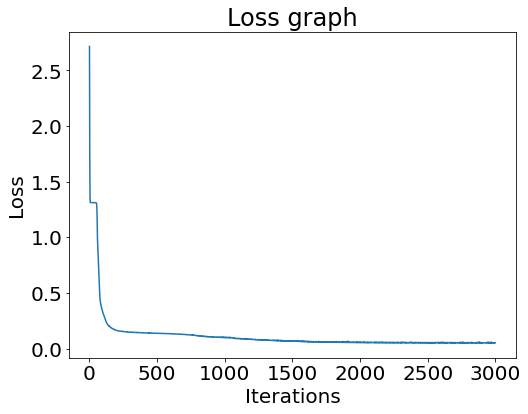

In [4]:


import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
# y = model.loss_array
y=a

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()



In [5]:
with h5py.File(r"C:\Users\Omkar\Desktop\Research Paper\PINN\lambda_array_2-D_case_2\lambda_array_2-D_case_2.hdf5") as f:
    data = f['default']
    b=np.array(data)
    

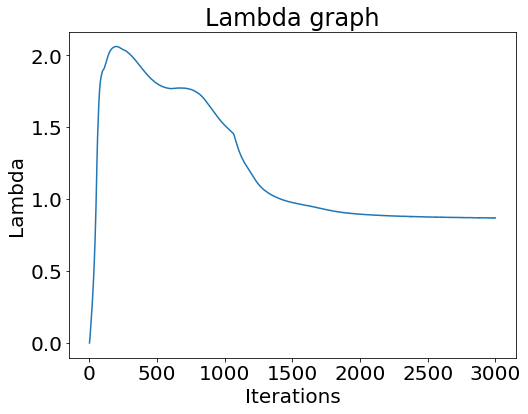

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
# y = model.lambda_array
y=b

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [4]:
noise2 = 0.01        
u_train2 = u_train + noise2*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_2 = q_ + noise2*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

q_t_2= tf.convert_to_tensor(q_2,dtype=tf.float32)



In [5]:
model2 = PhysicsInformedNN3(X_u_train, u_train2, layers1, lb1, ub1 , q_t_2)
model2.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 4.977e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.77
It: 10, Loss: 3.971e+00, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.18
It: 20, Loss: 3.145e+00, Lambda_1: 0.020, Lambda_2: 1.000000, Time: 0.12
It: 30, Loss: 2.500e+00, Lambda_1: 0.031, Lambda_2: 1.000000, Time: 0.13
It: 40, Loss: 2.026e+00, Lambda_1: 0.042, Lambda_2: 1.000000, Time: 0.13
It: 50, Loss: 1.703e+00, Lambda_1: 0.053, Lambda_2: 1.000000, Time: 0.12
It: 60, Loss: 1.501e+00, Lambda_1: 0.065, Lambda_2: 1.000000, Time: 0.12
It: 70, Loss: 1.388e+00, Lambda_1: 0.076, Lambda_2: 1.000000, Time: 0.11
It: 80, Loss: 1.333e+00, Lambda_1: 0

It: 1070, Loss: 3.627e-01, Lambda_1: 2.202, Lambda_2: 1.000000, Time: 0.12
It: 1080, Loss: 3.594e-01, Lambda_1: 2.200, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 3.563e-01, Lambda_1: 2.199, Lambda_2: 1.000000, Time: 0.13
It: 1100, Loss: 3.532e-01, Lambda_1: 2.197, Lambda_2: 1.000000, Time: 0.10
It: 1110, Loss: 3.503e-01, Lambda_1: 2.196, Lambda_2: 1.000000, Time: 0.11
It: 1120, Loss: 3.475e-01, Lambda_1: 2.194, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 3.447e-01, Lambda_1: 2.193, Lambda_2: 1.000000, Time: 0.12
It: 1140, Loss: 3.418e-01, Lambda_1: 2.192, Lambda_2: 1.000000, Time: 0.11
It: 1150, Loss: 3.389e-01, Lambda_1: 2.190, Lambda_2: 1.000000, Time: 0.13
It: 1160, Loss: 3.357e-01, Lambda_1: 2.189, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 3.321e-01, Lambda_1: 2.188, Lambda_2: 1.000000, Time: 0.12
It: 1180, Loss: 3.279e-01, Lambda_1: 2.186, Lambda_2: 1.000000, Time: 0.10
It: 1190, Loss: 3.229e-01, Lambda_1: 2.185, Lambda_2: 1.000000, Time: 0.11
It: 1200, Loss: 3.172e-01

It: 2170, Loss: 1.396e-01, Lambda_1: 2.302, Lambda_2: 1.000000, Time: 0.12
It: 2180, Loss: 1.395e-01, Lambda_1: 2.301, Lambda_2: 1.000000, Time: 0.11
It: 2190, Loss: 1.392e-01, Lambda_1: 2.299, Lambda_2: 1.000000, Time: 0.13
It: 2200, Loss: 1.390e-01, Lambda_1: 2.298, Lambda_2: 1.000000, Time: 0.10
It: 2210, Loss: 1.387e-01, Lambda_1: 2.296, Lambda_2: 1.000000, Time: 0.12
It: 2220, Loss: 1.385e-01, Lambda_1: 2.294, Lambda_2: 1.000000, Time: 0.11
It: 2230, Loss: 1.383e-01, Lambda_1: 2.293, Lambda_2: 1.000000, Time: 0.12
It: 2240, Loss: 1.381e-01, Lambda_1: 2.291, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 1.379e-01, Lambda_1: 2.289, Lambda_2: 1.000000, Time: 0.12
It: 2260, Loss: 1.377e-01, Lambda_1: 2.287, Lambda_2: 1.000000, Time: 0.11
It: 2270, Loss: 1.375e-01, Lambda_1: 2.286, Lambda_2: 1.000000, Time: 0.12
It: 2280, Loss: 1.373e-01, Lambda_1: 2.284, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 1.371e-01, Lambda_1: 2.282, Lambda_2: 1.000000, Time: 0.12
It: 2300, Loss: 1.369e-01

It: 3270, Loss: 1.231e-01, Lambda_1: 2.040, Lambda_2: 1.000000, Time: 0.11
It: 3280, Loss: 1.231e-01, Lambda_1: 2.037, Lambda_2: 1.000000, Time: 0.12
It: 3290, Loss: 1.230e-01, Lambda_1: 2.035, Lambda_2: 1.000000, Time: 0.10
It: 3300, Loss: 1.228e-01, Lambda_1: 2.032, Lambda_2: 1.000000, Time: 0.11
It: 3310, Loss: 1.227e-01, Lambda_1: 2.029, Lambda_2: 1.000000, Time: 0.13
It: 3320, Loss: 1.226e-01, Lambda_1: 2.027, Lambda_2: 1.000000, Time: 0.10
It: 3330, Loss: 1.224e-01, Lambda_1: 2.024, Lambda_2: 1.000000, Time: 0.12
It: 3340, Loss: 1.223e-01, Lambda_1: 2.021, Lambda_2: 1.000000, Time: 0.11
It: 3350, Loss: 1.222e-01, Lambda_1: 2.019, Lambda_2: 1.000000, Time: 0.13
It: 3360, Loss: 1.221e-01, Lambda_1: 2.016, Lambda_2: 1.000000, Time: 0.10
It: 3370, Loss: 1.220e-01, Lambda_1: 2.013, Lambda_2: 1.000000, Time: 0.12
It: 3380, Loss: 1.219e-01, Lambda_1: 2.011, Lambda_2: 1.000000, Time: 0.11
It: 3390, Loss: 1.218e-01, Lambda_1: 2.008, Lambda_2: 1.000000, Time: 0.13
It: 3400, Loss: 1.217e-01

It: 4370, Loss: 1.107e-01, Lambda_1: 1.794, Lambda_2: 1.000000, Time: 0.12
It: 4380, Loss: 1.104e-01, Lambda_1: 1.792, Lambda_2: 1.000000, Time: 0.10
It: 4390, Loss: 1.104e-01, Lambda_1: 1.791, Lambda_2: 1.000000, Time: 0.12
It: 4400, Loss: 1.098e-01, Lambda_1: 1.789, Lambda_2: 1.000000, Time: 0.11
It: 4410, Loss: 1.094e-01, Lambda_1: 1.787, Lambda_2: 1.000000, Time: 0.13
It: 4420, Loss: 1.091e-01, Lambda_1: 1.786, Lambda_2: 1.000000, Time: 0.10
It: 4430, Loss: 1.087e-01, Lambda_1: 1.784, Lambda_2: 1.000000, Time: 0.12
It: 4440, Loss: 1.084e-01, Lambda_1: 1.782, Lambda_2: 1.000000, Time: 0.11
It: 4450, Loss: 1.080e-01, Lambda_1: 1.780, Lambda_2: 1.000000, Time: 0.12
It: 4460, Loss: 1.076e-01, Lambda_1: 1.778, Lambda_2: 1.000000, Time: 0.11
It: 4470, Loss: 1.072e-01, Lambda_1: 1.776, Lambda_2: 1.000000, Time: 0.13
It: 4480, Loss: 1.068e-01, Lambda_1: 1.774, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 1.065e-01, Lambda_1: 1.772, Lambda_2: 1.000000, Time: 0.12
It: 4500, Loss: 1.059e-01

It: 5470, Loss: 7.280e-02, Lambda_1: 1.100, Lambda_2: 1.000000, Time: 0.11
It: 5480, Loss: 7.271e-02, Lambda_1: 1.096, Lambda_2: 1.000000, Time: 0.10
It: 5490, Loss: 7.263e-02, Lambda_1: 1.093, Lambda_2: 1.000000, Time: 0.11
It: 5500, Loss: 7.254e-02, Lambda_1: 1.089, Lambda_2: 1.000000, Time: 0.11
It: 5510, Loss: 7.246e-02, Lambda_1: 1.086, Lambda_2: 1.000000, Time: 0.12
It: 5520, Loss: 7.237e-02, Lambda_1: 1.082, Lambda_2: 1.000000, Time: 0.12
It: 5530, Loss: 7.229e-02, Lambda_1: 1.079, Lambda_2: 1.000000, Time: 0.13
It: 5540, Loss: 7.221e-02, Lambda_1: 1.076, Lambda_2: 1.000000, Time: 0.12
It: 5550, Loss: 7.213e-02, Lambda_1: 1.073, Lambda_2: 1.000000, Time: 0.12
It: 5560, Loss: 7.206e-02, Lambda_1: 1.070, Lambda_2: 1.000000, Time: 0.11
It: 5570, Loss: 7.198e-02, Lambda_1: 1.067, Lambda_2: 1.000000, Time: 0.12
It: 5580, Loss: 7.190e-02, Lambda_1: 1.064, Lambda_2: 1.000000, Time: 0.11
It: 5590, Loss: 7.183e-02, Lambda_1: 1.061, Lambda_2: 1.000000, Time: 0.12
It: 5600, Loss: 7.176e-02

It: 6570, Loss: 6.700e-02, Lambda_1: 0.953, Lambda_2: 1.000000, Time: 0.11
It: 6580, Loss: 6.693e-02, Lambda_1: 0.953, Lambda_2: 1.000000, Time: 0.11
It: 6590, Loss: 6.686e-02, Lambda_1: 0.952, Lambda_2: 1.000000, Time: 0.12
It: 6600, Loss: 6.680e-02, Lambda_1: 0.952, Lambda_2: 1.000000, Time: 0.11
It: 6610, Loss: 6.673e-02, Lambda_1: 0.951, Lambda_2: 1.000000, Time: 0.12
It: 6620, Loss: 6.666e-02, Lambda_1: 0.951, Lambda_2: 1.000000, Time: 0.11
It: 6630, Loss: 6.659e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 6.651e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.11
It: 6650, Loss: 6.644e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.13
It: 6660, Loss: 6.637e-02, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.12
It: 6670, Loss: 6.769e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.12
It: 6680, Loss: 6.664e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.11
It: 6690, Loss: 6.618e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.13
It: 6700, Loss: 6.621e-02

It: 7670, Loss: 6.141e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.11
It: 7680, Loss: 6.137e-02, Lambda_1: 0.885, Lambda_2: 1.000000, Time: 0.10
It: 7690, Loss: 6.133e-02, Lambda_1: 0.884, Lambda_2: 1.000000, Time: 0.12
It: 7700, Loss: 6.130e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.11
It: 7710, Loss: 6.127e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.13
It: 7720, Loss: 6.124e-02, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.12
It: 7730, Loss: 6.121e-02, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.12
It: 7740, Loss: 6.119e-02, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.11
It: 7750, Loss: 6.116e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 7760, Loss: 6.114e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.10
It: 7770, Loss: 6.111e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.11
It: 7780, Loss: 6.109e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.11
It: 7790, Loss: 6.106e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.12
It: 7800, Loss: 6.104e-02

It: 8780, Loss: 5.955e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.13
It: 8790, Loss: 5.954e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 8800, Loss: 5.953e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 8810, Loss: 5.952e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 8820, Loss: 5.951e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 8830, Loss: 5.954e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 8840, Loss: 6.193e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.13
It: 8850, Loss: 5.955e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 8860, Loss: 5.948e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 8870, Loss: 5.949e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8880, Loss: 5.947e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 5.943e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 8900, Loss: 5.941e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.13
It: 8910, Loss: 5.940e-02

It: 9880, Loss: 5.830e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.12
It: 9890, Loss: 5.829e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.11
It: 9900, Loss: 5.827e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.13
It: 9910, Loss: 5.826e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.11
It: 9920, Loss: 5.825e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.14
It: 9930, Loss: 5.824e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.11
It: 9940, Loss: 5.823e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.12
It: 9950, Loss: 5.822e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.11
It: 9960, Loss: 5.821e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.12
It: 9970, Loss: 5.819e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 9980, Loss: 5.818e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.13
It: 9990, Loss: 5.817e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 10000, Loss: 5.816e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.12
It: 10010, Loss: 5.815e-

It: 10960, Loss: 5.697e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 10970, Loss: 5.695e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 10980, Loss: 5.694e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 10990, Loss: 5.692e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11000, Loss: 5.691e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.14
It: 11010, Loss: 5.689e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11020, Loss: 5.688e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11030, Loss: 5.687e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11040, Loss: 5.685e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11050, Loss: 5.684e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11060, Loss: 5.683e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11070, Loss: 5.681e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11080, Loss: 5.680e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11090, L

It: 12040, Loss: 5.549e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.21
It: 12050, Loss: 5.548e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.22
It: 12060, Loss: 5.546e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.16
It: 12070, Loss: 5.545e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.17
It: 12080, Loss: 5.544e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.17
It: 12090, Loss: 5.542e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.16
It: 12100, Loss: 5.541e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.15
It: 12110, Loss: 5.540e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 12120, Loss: 5.553e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 12130, Loss: 5.570e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 12140, Loss: 5.539e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 12150, Loss: 5.535e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 12160, Loss: 5.535e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 12170, L

It: 13130, Loss: 5.418e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13140, Loss: 5.413e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.14
It: 13150, Loss: 5.413e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.14
It: 13160, Loss: 5.411e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13170, Loss: 5.410e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13180, Loss: 5.412e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13190, Loss: 5.439e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13200, Loss: 5.406e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13210, Loss: 5.410e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 13220, Loss: 5.407e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13230, Loss: 5.403e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.15
It: 13240, Loss: 5.403e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 13250, Loss: 5.403e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.14
It: 13260, L

It: 14220, Loss: 5.312e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.16
It: 14230, Loss: 5.308e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.21
It: 14240, Loss: 5.309e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.16
It: 14250, Loss: 5.307e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 14260, Loss: 5.306e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 14270, Loss: 5.304e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.19
It: 14280, Loss: 5.304e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.19
It: 14290, Loss: 5.312e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 14300, Loss: 5.334e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 14310, Loss: 5.317e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.19
It: 14320, Loss: 5.306e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 14330, Loss: 5.300e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.20
It: 14340, Loss: 5.298e-02, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.20
It: 14350, L

It: 15300, Loss: 5.216e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15310, Loss: 5.216e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 15320, Loss: 5.219e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15330, Loss: 5.272e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15340, Loss: 5.228e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15350, Loss: 5.217e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 15360, Loss: 5.212e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 15370, Loss: 5.210e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15380, Loss: 5.210e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15390, Loss: 5.208e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 15400, Loss: 5.208e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 15410, Loss: 5.208e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.21
It: 15420, Loss: 5.230e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 15430, L

It: 16380, Loss: 5.116e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 16390, Loss: 5.115e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 16400, Loss: 5.114e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.24
It: 16410, Loss: 5.113e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.17
It: 16420, Loss: 5.113e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 16430, Loss: 5.112e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 16440, Loss: 5.111e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 16450, Loss: 5.110e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.17
It: 16460, Loss: 5.109e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 16470, Loss: 5.130e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.17
It: 16480, Loss: 5.110e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.18
It: 16490, Loss: 5.131e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.19
It: 16500, Loss: 5.110e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.20
It: 16510, L

It: 17460, Loss: 5.014e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.21
It: 17470, Loss: 5.013e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.26
It: 17480, Loss: 5.013e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.27
It: 17490, Loss: 5.012e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.30
It: 17500, Loss: 5.011e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.30
It: 17510, Loss: 5.009e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.31
It: 17520, Loss: 5.008e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.29
It: 17530, Loss: 5.007e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.35
It: 17540, Loss: 5.006e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.28
It: 17550, Loss: 5.005e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.28
It: 17560, Loss: 5.005e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.28
It: 17570, Loss: 5.042e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.27
It: 17580, Loss: 5.087e-02, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.26
It: 17590, L

It: 18550, Loss: 4.923e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.18
It: 18560, Loss: 4.919e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.19
It: 18570, Loss: 4.918e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.19
It: 18580, Loss: 4.919e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.20
It: 18590, Loss: 4.917e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.20
It: 18600, Loss: 4.916e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.20
It: 18610, Loss: 4.918e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.19
It: 18620, Loss: 4.953e-02, Lambda_1: 0.852, Lambda_2: 1.000000, Time: 0.19
It: 18630, Loss: 4.914e-02, Lambda_1: 0.852, Lambda_2: 1.000000, Time: 0.19
It: 18640, Loss: 4.913e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.17
It: 18650, Loss: 4.912e-02, Lambda_1: 0.853, Lambda_2: 1.000000, Time: 0.20
It: 18660, Loss: 4.912e-02, Lambda_1: 0.852, Lambda_2: 1.000000, Time: 0.20
It: 18670, Loss: 4.911e-02, Lambda_1: 0.852, Lambda_2: 1.000000, Time: 0.19
It: 18680, L

It: 19630, Loss: 4.925e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.20
It: 19640, Loss: 4.866e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.18
It: 19650, Loss: 4.857e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.20
It: 19660, Loss: 4.852e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.20
It: 19670, Loss: 4.849e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.22
It: 19680, Loss: 4.848e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.21
It: 19690, Loss: 4.848e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.21
It: 19700, Loss: 4.847e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.22
It: 19710, Loss: 4.846e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.22
It: 19720, Loss: 4.848e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.25
It: 19730, Loss: 4.899e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.25
It: 19740, Loss: 4.846e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.25
It: 19750, Loss: 4.859e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.27
It: 19760, L

It: 20720, Loss: 4.802e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.19
It: 20730, Loss: 4.801e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.19
It: 20740, Loss: 4.801e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.21
It: 20750, Loss: 4.801e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.21
It: 20760, Loss: 4.800e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.20
It: 20770, Loss: 4.800e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.20
It: 20780, Loss: 4.818e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.19
It: 20790, Loss: 4.828e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.18
It: 20800, Loss: 4.849e-02, Lambda_1: 0.840, Lambda_2: 1.000000, Time: 0.19
It: 20810, Loss: 4.814e-02, Lambda_1: 0.840, Lambda_2: 1.000000, Time: 0.19
It: 20820, Loss: 4.804e-02, Lambda_1: 0.840, Lambda_2: 1.000000, Time: 0.20
It: 20830, Loss: 4.801e-02, Lambda_1: 0.840, Lambda_2: 1.000000, Time: 0.18
It: 20840, Loss: 4.798e-02, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.19
It: 20850, L

It: 21800, Loss: 4.769e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.21
It: 21810, Loss: 4.768e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.22
It: 21820, Loss: 4.768e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.19
It: 21830, Loss: 4.769e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.20
It: 21840, Loss: 4.781e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.20
It: 21850, Loss: 4.946e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.20
It: 21860, Loss: 4.802e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.18
It: 21870, Loss: 4.777e-02, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.20
It: 21880, Loss: 4.769e-02, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.19
It: 21890, Loss: 4.768e-02, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.20
It: 21900, Loss: 4.766e-02, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.19
It: 21910, Loss: 4.766e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.20
It: 21920, Loss: 4.765e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.19
It: 21930, L

It: 22880, Loss: 4.742e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.19
It: 22890, Loss: 4.742e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.19
It: 22900, Loss: 4.742e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.20
It: 22910, Loss: 4.742e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.20
It: 22920, Loss: 4.741e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.17
It: 22930, Loss: 4.741e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.20
It: 22940, Loss: 4.741e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.21
It: 22950, Loss: 4.741e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.18
It: 22960, Loss: 4.750e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.19
It: 22970, Loss: 4.923e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.17
It: 22980, Loss: 4.774e-02, Lambda_1: 0.831, Lambda_2: 1.000000, Time: 0.18
It: 22990, Loss: 4.740e-02, Lambda_1: 0.832, Lambda_2: 1.000000, Time: 0.17
It: 23000, Loss: 4.741e-02, Lambda_1: 0.832, Lambda_2: 1.000000, Time: 0.19
It: 23010, L

It: 23970, Loss: 4.719e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.18
It: 23980, Loss: 4.719e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.23
It: 23990, Loss: 4.719e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.16
It: 24000, Loss: 4.718e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.17
It: 24010, Loss: 4.718e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.19
It: 24020, Loss: 4.718e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.19
It: 24030, Loss: 4.718e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.17
It: 24040, Loss: 4.718e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.18
It: 24050, Loss: 4.717e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.19
It: 24060, Loss: 4.717e-02, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.18
It: 24070, Loss: 4.717e-02, Lambda_1: 0.828, Lambda_2: 1.000000, Time: 0.19
It: 24080, Loss: 4.717e-02, Lambda_1: 0.828, Lambda_2: 1.000000, Time: 0.19
It: 24090, Loss: 4.717e-02, Lambda_1: 0.828, Lambda_2: 1.000000, Time: 0.17
It: 24100, L

It: 25050, Loss: 4.699e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25060, Loss: 4.699e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25070, Loss: 4.699e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25080, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25090, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25100, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25110, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25120, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25130, Loss: 4.698e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25140, Loss: 4.697e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25150, Loss: 4.697e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.19
It: 25160, Loss: 4.697e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.20
It: 25170, Loss: 4.697e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 25180, L

It: 26130, Loss: 4.854e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 26140, Loss: 4.760e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.17
It: 26150, Loss: 4.692e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.18
It: 26160, Loss: 4.684e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.17
It: 26170, Loss: 4.685e-02, Lambda_1: 0.827, Lambda_2: 1.000000, Time: 0.18
It: 26180, Loss: 4.682e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 26190, Loss: 4.682e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.20
It: 26200, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.18
It: 26210, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 26220, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.18
It: 26230, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 26240, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.20
It: 26250, Loss: 4.681e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.20
It: 26260, L

It: 27220, Loss: 4.667e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.20
It: 27230, Loss: 4.667e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 27240, Loss: 4.667e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 27250, Loss: 4.666e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 27260, Loss: 4.666e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.19
It: 27270, Loss: 4.666e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.21
It: 27280, Loss: 4.666e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.21
It: 27290, Loss: 4.666e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.20
It: 27300, Loss: 4.666e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.21
It: 27310, Loss: 4.666e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.23
It: 27320, Loss: 4.665e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.23
It: 27330, Loss: 4.665e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 27340, Loss: 4.665e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 27350, L

It: 28300, Loss: 4.654e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.25
It: 28310, Loss: 4.653e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.27
It: 28320, Loss: 4.652e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.25
It: 28330, Loss: 4.652e-02, Lambda_1: 0.826, Lambda_2: 1.000000, Time: 0.24
It: 28340, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 28350, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.23
It: 28360, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 28370, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 28380, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.20
It: 28390, Loss: 4.652e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 28400, Loss: 4.651e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.22
It: 28410, Loss: 4.651e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.23
It: 28420, Loss: 4.651e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.26
It: 28430, L

It: 29380, Loss: 4.640e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.28
It: 29390, Loss: 4.640e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.34
It: 29400, Loss: 4.640e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.33
It: 29410, Loss: 4.640e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.32
It: 29420, Loss: 4.640e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.43
It: 29430, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.28
It: 29440, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.30
It: 29450, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.30
It: 29460, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.29
It: 29470, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.37
It: 29480, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.27
It: 29490, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.28
It: 29500, Loss: 4.639e-02, Lambda_1: 0.825, Lambda_2: 1.000000, Time: 0.31
It: 29510, L

In [6]:
np_loss_array_2=np.array(model2.loss_array)

with h5py.File('loss_array_2.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_2)





np_lambda_array_2 = np.array(model2.lambda_array)

with h5py.File('lambda_array_2.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_2)

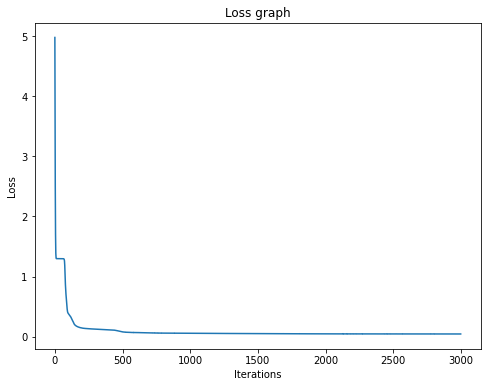

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model2.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()



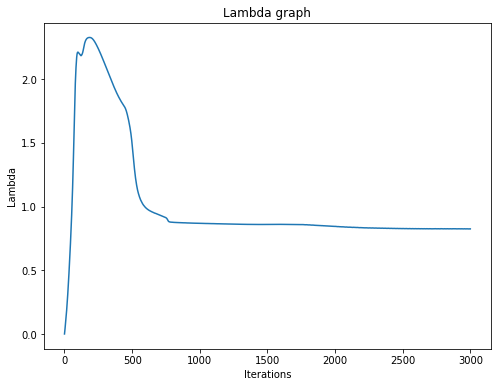

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model2.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [4]:
noise3 = 0.05        
u_train3 = u_train + noise3*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_3 = q_ + noise3*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

q_t_3= tf.convert_to_tensor(q_3,dtype=tf.float32)


In [5]:
model3 = PhysicsInformedNN3(X_u_train, u_train3, layers1, lb1, ub1 , q_t_3)
model3.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 1.799e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.95
It: 10, Loss: 1.481e+00, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.22
It: 20, Loss: 1.343e+00, Lambda_1: 0.021, Lambda_2: 1.000000, Time: 0.19
It: 30, Loss: 1.324e+00, Lambda_1: 0.032, Lambda_2: 1.000000, Time: 0.20
It: 40, Loss: 1.329e+00, Lambda_1: 0.044, Lambda_2: 1.000000, Time: 0.22
It: 50, Loss: 1.325e+00, Lambda_1: 0.055, Lambda_2: 1.000000, Time: 0.21
It: 60, Loss: 1.323e+00, Lambda_1: 0.067, Lambda_2: 1.000000, Time: 0.20
It: 70, Loss: 1.324e+00, Lambda_1: 0.078, Lambda_2: 1.000000, Time: 0.18
It: 80, Loss: 1.324e+00, Lambda_1: 0

It: 1070, Loss: 2.839e-01, Lambda_1: 1.589, Lambda_2: 1.000000, Time: 0.11
It: 1080, Loss: 2.826e-01, Lambda_1: 1.587, Lambda_2: 1.000000, Time: 0.12
It: 1090, Loss: 2.813e-01, Lambda_1: 1.584, Lambda_2: 1.000000, Time: 0.12
It: 1100, Loss: 2.800e-01, Lambda_1: 1.582, Lambda_2: 1.000000, Time: 0.12
It: 1110, Loss: 2.814e-01, Lambda_1: 1.580, Lambda_2: 1.000000, Time: 0.10
It: 1120, Loss: 2.780e-01, Lambda_1: 1.577, Lambda_2: 1.000000, Time: 0.10
It: 1130, Loss: 2.770e-01, Lambda_1: 1.574, Lambda_2: 1.000000, Time: 0.11
It: 1140, Loss: 2.758e-01, Lambda_1: 1.572, Lambda_2: 1.000000, Time: 0.10
It: 1150, Loss: 2.748e-01, Lambda_1: 1.569, Lambda_2: 1.000000, Time: 0.12
It: 1160, Loss: 2.739e-01, Lambda_1: 1.566, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 2.729e-01, Lambda_1: 1.563, Lambda_2: 1.000000, Time: 0.14
It: 1180, Loss: 2.720e-01, Lambda_1: 1.560, Lambda_2: 1.000000, Time: 0.11
It: 1190, Loss: 2.711e-01, Lambda_1: 1.557, Lambda_2: 1.000000, Time: 0.11
It: 1200, Loss: 2.701e-01

It: 2190, Loss: 1.479e-01, Lambda_1: 1.067, Lambda_2: 1.000000, Time: 0.09
It: 2200, Loss: 1.470e-01, Lambda_1: 1.063, Lambda_2: 1.000000, Time: 0.09
It: 2210, Loss: 1.459e-01, Lambda_1: 1.059, Lambda_2: 1.000000, Time: 0.12
It: 2220, Loss: 1.449e-01, Lambda_1: 1.055, Lambda_2: 1.000000, Time: 0.11
It: 2230, Loss: 1.439e-01, Lambda_1: 1.050, Lambda_2: 1.000000, Time: 0.12
It: 2240, Loss: 1.430e-01, Lambda_1: 1.046, Lambda_2: 1.000000, Time: 0.13
It: 2250, Loss: 1.422e-01, Lambda_1: 1.042, Lambda_2: 1.000000, Time: 0.11
It: 2260, Loss: 1.440e-01, Lambda_1: 1.038, Lambda_2: 1.000000, Time: 0.13
It: 2270, Loss: 1.407e-01, Lambda_1: 1.034, Lambda_2: 1.000000, Time: 0.11
It: 2280, Loss: 1.396e-01, Lambda_1: 1.031, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 1.389e-01, Lambda_1: 1.027, Lambda_2: 1.000000, Time: 0.12
It: 2300, Loss: 1.380e-01, Lambda_1: 1.024, Lambda_2: 1.000000, Time: 0.09
It: 2310, Loss: 1.372e-01, Lambda_1: 1.020, Lambda_2: 1.000000, Time: 0.09
It: 2320, Loss: 1.364e-01

It: 3300, Loss: 9.978e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.12
It: 3310, Loss: 9.976e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.12
It: 3320, Loss: 1.034e-01, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 1.002e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 3340, Loss: 9.897e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.10
It: 3350, Loss: 9.879e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 3360, Loss: 9.859e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.12
It: 3370, Loss: 9.837e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.12
It: 3380, Loss: 9.819e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.10
It: 3390, Loss: 9.798e-02, Lambda_1: 0.895, Lambda_2: 1.000000, Time: 0.11
It: 3400, Loss: 9.781e-02, Lambda_1: 0.895, Lambda_2: 1.000000, Time: 0.12
It: 3410, Loss: 9.837e-02, Lambda_1: 0.895, Lambda_2: 1.000000, Time: 0.12
It: 3420, Loss: 9.811e-02, Lambda_1: 0.894, Lambda_2: 1.000000, Time: 0.11
It: 3430, Loss: 9.725e-02

It: 4400, Loss: 8.523e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 4410, Loss: 8.881e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 4420, Loss: 8.545e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.13
It: 4430, Loss: 8.474e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.10
It: 4440, Loss: 8.475e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 4450, Loss: 8.464e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 4460, Loss: 8.452e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.14
It: 4470, Loss: 8.442e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 8.433e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 4490, Loss: 8.426e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.11
It: 4500, Loss: 8.418e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 4510, Loss: 8.410e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 4520, Loss: 8.402e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 4530, Loss: 8.405e-02

It: 5510, Loss: 7.892e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 5520, Loss: 7.904e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5530, Loss: 8.170e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5540, Loss: 7.937e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5550, Loss: 7.884e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 5560, Loss: 7.873e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5570, Loss: 7.876e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 5580, Loss: 7.868e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.10
It: 5590, Loss: 7.866e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5600, Loss: 7.865e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5610, Loss: 7.917e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 5620, Loss: 7.983e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.10
It: 5630, Loss: 7.908e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 5640, Loss: 7.845e-02

It: 6610, Loss: 7.553e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.11
It: 6620, Loss: 7.599e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.11
It: 6630, Loss: 7.565e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 7.546e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.11
It: 6650, Loss: 7.572e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.13
It: 6660, Loss: 7.710e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.10
It: 6670, Loss: 7.543e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 6680, Loss: 7.585e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 6690, Loss: 7.537e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.12
It: 6700, Loss: 7.561e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 6710, Loss: 7.548e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.13
It: 6720, Loss: 7.541e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.10
It: 6730, Loss: 7.594e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.11
It: 6740, Loss: 7.582e-02

It: 7710, Loss: 7.322e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.13
It: 7720, Loss: 7.284e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7730, Loss: 7.352e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.13
It: 7740, Loss: 7.278e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7750, Loss: 7.290e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7760, Loss: 7.354e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7770, Loss: 7.265e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.12
It: 7780, Loss: 7.281e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7790, Loss: 7.351e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.13
It: 7800, Loss: 7.262e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.10
It: 7810, Loss: 7.271e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7820, Loss: 7.341e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 7830, Loss: 7.255e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.12
It: 7840, Loss: 7.257e-02

It: 8810, Loss: 6.995e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8820, Loss: 7.067e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8830, Loss: 6.990e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 8840, Loss: 7.034e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8850, Loss: 6.998e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.13
It: 8860, Loss: 6.994e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.10
It: 8870, Loss: 7.059e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8880, Loss: 6.983e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8890, Loss: 6.989e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 8900, Loss: 7.069e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.11
It: 8910, Loss: 6.972e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.12
It: 8920, Loss: 7.013e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.10
It: 8930, Loss: 7.011e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.13
It: 8940, Loss: 6.987e-02

It: 9910, Loss: 6.818e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 9920, Loss: 6.809e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 9930, Loss: 6.814e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.12
It: 9940, Loss: 6.811e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 9950, Loss: 6.807e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.12
It: 9960, Loss: 6.799e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 9970, Loss: 6.780e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.12
It: 9980, Loss: 6.838e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.12
It: 9990, Loss: 6.757e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.12
It: 10000, Loss: 6.817e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.11
It: 10010, Loss: 6.782e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.12
It: 10020, Loss: 6.786e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.11
It: 10030, Loss: 6.833e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.13
It: 10040, Loss: 6.78

It: 11000, Loss: 6.671e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11010, Loss: 6.710e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11020, Loss: 6.639e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11030, Loss: 6.714e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.10
It: 11040, Loss: 6.655e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11050, Loss: 6.685e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11060, Loss: 6.692e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11070, Loss: 6.687e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11080, Loss: 6.672e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 11090, Loss: 6.671e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11100, Loss: 6.684e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11110, Loss: 6.634e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 11120, Loss: 6.712e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 11130, L

It: 12080, Loss: 6.550e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 12090, Loss: 6.605e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12100, Loss: 6.592e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12110, Loss: 6.559e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12120, Loss: 6.666e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 12130, Loss: 6.546e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12140, Loss: 6.665e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 12150, Loss: 6.546e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.10
It: 12160, Loss: 6.632e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12170, Loss: 6.547e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12180, Loss: 6.595e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12190, Loss: 6.588e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 12200, Loss: 6.550e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 12210, L

It: 13160, Loss: 6.493e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.12
It: 13170, Loss: 6.597e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.11
It: 13180, Loss: 6.482e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.13
It: 13190, Loss: 6.585e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.11
It: 13200, Loss: 6.487e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.13
It: 13210, Loss: 6.546e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.11
It: 13220, Loss: 6.509e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.13
It: 13230, Loss: 6.509e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.12
It: 13240, Loss: 6.576e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.12
It: 13250, Loss: 6.481e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.11
It: 13260, Loss: 6.574e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.13
It: 13270, Loss: 6.483e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.11
It: 13280, Loss: 6.548e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.13
It: 13290, L

It: 14240, Loss: 6.496e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14250, Loss: 6.448e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.12
It: 14260, Loss: 6.546e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14270, Loss: 6.428e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.12
It: 14280, Loss: 6.508e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14290, Loss: 6.447e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.11
It: 14300, Loss: 6.468e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 14310, Loss: 6.519e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14320, Loss: 6.438e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14330, Loss: 6.535e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.11
It: 14340, Loss: 6.425e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 14350, Loss: 6.505e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.11
It: 14360, Loss: 6.452e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 14370, L

It: 15320, Loss: 6.424e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15330, Loss: 6.409e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 15340, Loss: 6.492e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15350, Loss: 6.384e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 15360, Loss: 6.477e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15370, Loss: 6.404e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15380, Loss: 6.416e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15390, Loss: 6.480e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.13
It: 15400, Loss: 6.386e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15410, Loss: 6.491e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15420, Loss: 6.390e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15430, Loss: 6.424e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15440, Loss: 6.462e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 15450, L

It: 16400, Loss: 6.383e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16410, Loss: 6.459e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16420, Loss: 6.347e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.16
It: 16430, Loss: 6.438e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16440, Loss: 6.362e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16450, Loss: 6.377e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16460, Loss: 6.462e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16470, Loss: 6.344e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16480, Loss: 6.429e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16490, Loss: 6.368e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16500, Loss: 6.370e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16510, Loss: 6.469e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.14
It: 16520, Loss: 6.341e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.16
It: 16530, L

It: 17490, Loss: 6.306e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 17500, Loss: 6.369e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 17510, Loss: 6.370e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 17520, Loss: 6.317e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 17530, Loss: 6.438e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.16
It: 17540, Loss: 6.310e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.16
It: 17550, Loss: 6.348e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 17560, Loss: 6.399e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.17
It: 17570, Loss: 6.308e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 17580, Loss: 6.415e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.19
It: 17590, Loss: 6.324e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 17600, Loss: 6.331e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.17
It: 17610, Loss: 6.420e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.18
It: 17620, L

It: 18580, Loss: 6.276e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18590, Loss: 6.305e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.22
It: 18600, Loss: 6.378e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.19
It: 18610, Loss: 6.269e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18620, Loss: 6.363e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18630, Loss: 6.308e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.19
It: 18640, Loss: 6.284e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18650, Loss: 6.394e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18660, Loss: 6.267e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.19
It: 18670, Loss: 6.319e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18680, Loss: 6.365e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.22
It: 18690, Loss: 6.269e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18700, Loss: 6.367e-02, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.20
It: 18710, L

It: 19670, Loss: 6.240e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.19
It: 19680, Loss: 6.266e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.24
It: 19690, Loss: 6.372e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.18
It: 19700, Loss: 6.230e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.19
It: 19710, Loss: 6.299e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.19
It: 19720, Loss: 6.295e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.18
It: 19730, Loss: 6.237e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.19
It: 19740, Loss: 6.361e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.21
It: 19750, Loss: 6.245e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.21
It: 19760, Loss: 6.254e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.18
It: 19770, Loss: 6.359e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.18
It: 19780, Loss: 6.227e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.19
It: 19790, Loss: 6.290e-02, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.18
It: 19800, L

It: 20750, Loss: 6.213e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.20
It: 20760, Loss: 6.227e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.22
It: 20770, Loss: 6.354e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.23
It: 20780, Loss: 6.197e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.23
It: 20790, Loss: 6.254e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.25
It: 20800, Loss: 6.286e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.23
It: 20810, Loss: 6.201e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.20
It: 20820, Loss: 6.311e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.19
It: 20830, Loss: 6.231e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.18
It: 20840, Loss: 6.213e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.17
It: 20850, Loss: 6.331e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.19
It: 20860, Loss: 6.199e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.18
It: 20870, Loss: 6.240e-02, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.17
It: 20880, L

It: 21830, Loss: 6.311e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21840, Loss: 6.171e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21850, Loss: 6.231e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21860, Loss: 6.282e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21870, Loss: 6.174e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21880, Loss: 6.270e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.17
It: 21890, Loss: 6.208e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.18
It: 21900, Loss: 6.186e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.19
It: 21910, Loss: 6.331e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21920, Loss: 6.176e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21930, Loss: 6.205e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.15
It: 21940, Loss: 6.297e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.17
It: 21950, Loss: 6.169e-02, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 21960, L

It: 22910, Loss: 6.150e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.28
It: 22920, Loss: 6.241e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.28
It: 22930, Loss: 6.196e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.29
It: 22940, Loss: 6.159e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.31
It: 22950, Loss: 6.305e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.28
It: 22960, Loss: 6.160e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.28
It: 22970, Loss: 6.174e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.27
It: 22980, Loss: 6.291e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.27
It: 22990, Loss: 6.147e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.29
It: 23000, Loss: 6.206e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.32
It: 23010, Loss: 6.265e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.25
It: 23020, Loss: 6.148e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.26
It: 23030, Loss: 6.239e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.27
It: 23040, L

It: 23990, Loss: 6.179e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.28
It: 24000, Loss: 6.262e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.28
It: 24010, Loss: 6.128e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.27
It: 24020, Loss: 6.208e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.30
It: 24030, Loss: 6.192e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.35
It: 24040, Loss: 6.135e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.27
It: 24050, Loss: 6.276e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.28
It: 24060, Loss: 6.147e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.30
It: 24070, Loss: 6.146e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.34
It: 24080, Loss: 6.278e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.30
It: 24090, Loss: 6.128e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.30
It: 24100, Loss: 6.171e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.27
It: 24110, Loss: 6.274e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.27
It: 24120, L

It: 25070, Loss: 6.219e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.23
It: 25080, Loss: 6.143e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25090, Loss: 6.121e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.23
It: 25100, Loss: 6.287e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.25
It: 25110, Loss: 6.114e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25120, Loss: 6.138e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25130, Loss: 6.252e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.23
It: 25140, Loss: 6.106e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25150, Loss: 6.171e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.22
It: 25160, Loss: 6.222e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25170, Loss: 6.108e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25180, Loss: 6.210e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.24
It: 25190, Loss: 6.146e-02, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.26
It: 25200, L

It: 26150, Loss: 6.280e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.28
It: 26160, Loss: 6.091e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.26
It: 26170, Loss: 6.122e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.26
It: 26180, Loss: 6.231e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.23
It: 26190, Loss: 6.086e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.24
It: 26200, Loss: 6.165e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.24
It: 26210, Loss: 6.182e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.24
It: 26220, Loss: 6.090e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.25
It: 26230, Loss: 6.204e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.27
It: 26240, Loss: 6.117e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.26
It: 26250, Loss: 6.100e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.24
It: 26260, Loss: 6.277e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.25
It: 26270, Loss: 6.091e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.26
It: 26280, L

It: 27240, Loss: 6.073e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.25
It: 27250, Loss: 6.234e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.23
It: 27260, Loss: 6.085e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.18
It: 27270, Loss: 6.084e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.18
It: 27280, Loss: 6.234e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.18
It: 27290, Loss: 6.067e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.17
It: 27300, Loss: 6.114e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.18
It: 27310, Loss: 6.217e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.17
It: 27320, Loss: 6.065e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.20
It: 27330, Loss: 6.147e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.24
It: 27340, Loss: 6.132e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.16
It: 27350, Loss: 6.071e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.17
It: 27360, Loss: 6.231e-02, Lambda_1: 0.867, Lambda_2: 1.000000, Time: 0.16
It: 27370, L

It: 28330, Loss: 6.197e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.18
It: 28340, Loss: 6.044e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.22
It: 28350, Loss: 6.126e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.14
It: 28360, Loss: 6.140e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 28370, Loss: 6.047e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.14
It: 28380, Loss: 6.164e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.15
It: 28390, Loss: 6.079e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.24
It: 28400, Loss: 6.056e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.16
It: 28410, Loss: 6.247e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.19
It: 28420, Loss: 6.051e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.21
It: 28430, Loss: 6.070e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 28440, Loss: 6.209e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.18
It: 28450, Loss: 6.042e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 28460, L

It: 29420, Loss: 6.105e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.16
It: 29430, Loss: 6.023e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.22
It: 29440, Loss: 6.023e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.16
It: 29450, Loss: 6.082e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.18
It: 29460, Loss: 6.112e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.16
It: 29470, Loss: 6.147e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.18
It: 29480, Loss: 6.059e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.22
It: 29490, Loss: 6.021e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.15
It: 29500, Loss: 6.049e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 29510, Loss: 6.219e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 29520, Loss: 6.046e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.17
It: 29530, Loss: 6.176e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.20
It: 29540, Loss: 6.027e-02, Lambda_1: 0.868, Lambda_2: 1.000000, Time: 0.18
It: 29550, L

In [6]:
np_loss_array_3=np.array(model3.loss_array)

with h5py.File('loss_array_3.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_3)

np_lambda_array_3 = np.array(model3.lambda_array)

with h5py.File('lambda_array_3.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_3)

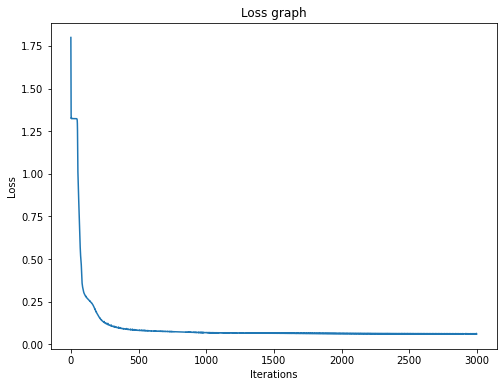

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model3.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

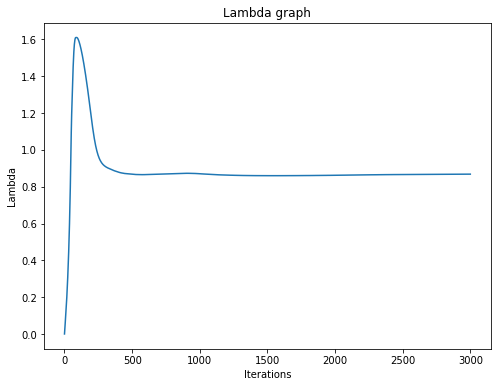

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model3.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [4]:
noise4 = 0.10       
u_train4 = u_train + noise4*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_4 = q_ + noise4*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])

q_t_4= tf.convert_to_tensor(q_4,dtype=tf.float32)



In [5]:
model4 = PhysicsInformedNN3(X_u_train, u_train4, layers1, lb1, ub1 , q_t_4)
model4.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 2.711e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.41
It: 10, Loss: 2.393e+00, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.11
It: 20, Loss: 2.208e+00, Lambda_1: 0.018, Lambda_2: 1.000000, Time: 0.08
It: 30, Loss: 2.133e+00, Lambda_1: 0.024, Lambda_2: 1.000000, Time: 0.09
It: 40, Loss: 2.119e+00, Lambda_1: 0.029, Lambda_2: 1.000000, Time: 0.08
It: 50, Loss: 2.121e+00, Lambda_1: 0.033, Lambda_2: 1.000000, Time: 0.08
It: 60, Loss: 2.121e+00, Lambda_1: 0.037, Lambda_2: 1.000000, Time: 0.08
It: 70, Loss: 2.119e+00, Lambda_1: 0.041, Lambda_2: 1.000000, Time: 0.08
It: 80, Loss: 2.119e+00, Lambda_1: 0

It: 1080, Loss: 9.544e-01, Lambda_1: 1.466, Lambda_2: 1.000000, Time: 0.07
It: 1090, Loss: 9.465e-01, Lambda_1: 1.454, Lambda_2: 1.000000, Time: 0.08
It: 1100, Loss: 9.381e-01, Lambda_1: 1.442, Lambda_2: 1.000000, Time: 0.07
It: 1110, Loss: 9.284e-01, Lambda_1: 1.429, Lambda_2: 1.000000, Time: 0.07
It: 1120, Loss: 9.185e-01, Lambda_1: 1.418, Lambda_2: 1.000000, Time: 0.07
It: 1130, Loss: 9.088e-01, Lambda_1: 1.406, Lambda_2: 1.000000, Time: 0.08
It: 1140, Loss: 8.991e-01, Lambda_1: 1.395, Lambda_2: 1.000000, Time: 0.08
It: 1150, Loss: 8.915e-01, Lambda_1: 1.386, Lambda_2: 1.000000, Time: 0.07
It: 1160, Loss: 8.823e-01, Lambda_1: 1.377, Lambda_2: 1.000000, Time: 0.08
It: 1170, Loss: 8.757e-01, Lambda_1: 1.369, Lambda_2: 1.000000, Time: 0.07
It: 1180, Loss: 8.690e-01, Lambda_1: 1.362, Lambda_2: 1.000000, Time: 0.07
It: 1190, Loss: 8.626e-01, Lambda_1: 1.356, Lambda_2: 1.000000, Time: 0.07
It: 1200, Loss: 8.565e-01, Lambda_1: 1.351, Lambda_2: 1.000000, Time: 0.07
It: 1210, Loss: 8.526e-01

It: 2180, Loss: 6.610e-01, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.08
It: 2190, Loss: 6.582e-01, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.08
It: 2200, Loss: 6.602e-01, Lambda_1: 0.995, Lambda_2: 1.000000, Time: 0.09
It: 2210, Loss: 6.561e-01, Lambda_1: 0.992, Lambda_2: 1.000000, Time: 0.09
It: 2220, Loss: 6.563e-01, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.08
It: 2230, Loss: 6.578e-01, Lambda_1: 0.985, Lambda_2: 1.000000, Time: 0.08
It: 2240, Loss: 6.573e-01, Lambda_1: 0.982, Lambda_2: 1.000000, Time: 0.09
It: 2250, Loss: 6.535e-01, Lambda_1: 0.979, Lambda_2: 1.000000, Time: 0.08
It: 2260, Loss: 6.546e-01, Lambda_1: 0.976, Lambda_2: 1.000000, Time: 0.08
It: 2270, Loss: 6.540e-01, Lambda_1: 0.973, Lambda_2: 1.000000, Time: 0.08
It: 2280, Loss: 6.518e-01, Lambda_1: 0.970, Lambda_2: 1.000000, Time: 0.08
It: 2290, Loss: 6.553e-01, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.08
It: 2300, Loss: 6.506e-01, Lambda_1: 0.965, Lambda_2: 1.000000, Time: 0.08
It: 2310, Loss: 6.508e-01

It: 3280, Loss: 6.012e-01, Lambda_1: 0.839, Lambda_2: 1.000000, Time: 0.08
It: 3290, Loss: 5.981e-01, Lambda_1: 0.838, Lambda_2: 1.000000, Time: 0.08
It: 3300, Loss: 5.972e-01, Lambda_1: 0.838, Lambda_2: 1.000000, Time: 0.08
It: 3310, Loss: 5.966e-01, Lambda_1: 0.838, Lambda_2: 1.000000, Time: 0.08
It: 3320, Loss: 5.996e-01, Lambda_1: 0.838, Lambda_2: 1.000000, Time: 0.08
It: 3330, Loss: 5.955e-01, Lambda_1: 0.837, Lambda_2: 1.000000, Time: 0.10
It: 3340, Loss: 5.952e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.09
It: 3350, Loss: 5.955e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.08
It: 3360, Loss: 5.937e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.08
It: 3370, Loss: 5.936e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.08
It: 3380, Loss: 5.983e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.08
It: 3390, Loss: 5.925e-01, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.09
It: 3400, Loss: 5.921e-01, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.08
It: 3410, Loss: 5.908e-01

It: 4390, Loss: 5.245e-01, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.08
It: 4400, Loss: 5.243e-01, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.08
It: 4410, Loss: 5.226e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4420, Loss: 5.246e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4430, Loss: 5.218e-01, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.08
It: 4440, Loss: 5.215e-01, Lambda_1: 0.828, Lambda_2: 1.000000, Time: 0.08
It: 4450, Loss: 5.213e-01, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.08
It: 4460, Loss: 5.201e-01, Lambda_1: 0.829, Lambda_2: 1.000000, Time: 0.08
It: 4470, Loss: 5.196e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4480, Loss: 5.198e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4490, Loss: 5.171e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4500, Loss: 5.162e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4510, Loss: 5.229e-01, Lambda_1: 0.830, Lambda_2: 1.000000, Time: 0.08
It: 4520, Loss: 5.152e-01

It: 5510, Loss: 4.370e-01, Lambda_1: 0.844, Lambda_2: 1.000000, Time: 0.08
It: 5520, Loss: 4.358e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.08
It: 5530, Loss: 4.399e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.09
It: 5540, Loss: 4.331e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.09
It: 5550, Loss: 4.362e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.09
It: 5560, Loss: 4.337e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.09
It: 5570, Loss: 4.307e-01, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.09
It: 5580, Loss: 4.299e-01, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.09
It: 5590, Loss: 4.391e-01, Lambda_1: 0.847, Lambda_2: 1.000000, Time: 0.08
It: 5600, Loss: 4.345e-01, Lambda_1: 0.844, Lambda_2: 1.000000, Time: 0.08
It: 5610, Loss: 4.314e-01, Lambda_1: 0.843, Lambda_2: 1.000000, Time: 0.08
It: 5620, Loss: 4.290e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.08
It: 5630, Loss: 4.275e-01, Lambda_1: 0.845, Lambda_2: 1.000000, Time: 0.08
It: 5640, Loss: 4.251e-01

It: 6630, Loss: 3.598e-01, Lambda_1: 0.817, Lambda_2: 1.000000, Time: 0.09
It: 6640, Loss: 3.607e-01, Lambda_1: 0.818, Lambda_2: 1.000000, Time: 0.08
It: 6650, Loss: 3.589e-01, Lambda_1: 0.817, Lambda_2: 1.000000, Time: 0.09
It: 6660, Loss: 3.572e-01, Lambda_1: 0.817, Lambda_2: 1.000000, Time: 0.09
It: 6670, Loss: 3.619e-01, Lambda_1: 0.818, Lambda_2: 1.000000, Time: 0.09
It: 6680, Loss: 3.559e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.09
It: 6690, Loss: 3.576e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.10
It: 6700, Loss: 3.559e-01, Lambda_1: 0.817, Lambda_2: 1.000000, Time: 0.09
It: 6710, Loss: 3.579e-01, Lambda_1: 0.815, Lambda_2: 1.000000, Time: 0.09
It: 6720, Loss: 3.557e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.09
It: 6730, Loss: 3.542e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.09
It: 6740, Loss: 3.533e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.09
It: 6750, Loss: 3.588e-01, Lambda_1: 0.816, Lambda_2: 1.000000, Time: 0.09
It: 6760, Loss: 3.524e-01

It: 7730, Loss: 3.150e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7740, Loss: 3.128e-01, Lambda_1: 0.801, Lambda_2: 1.000000, Time: 0.09
It: 7750, Loss: 3.178e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7760, Loss: 3.118e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7770, Loss: 3.134e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7780, Loss: 3.133e-01, Lambda_1: 0.799, Lambda_2: 1.000000, Time: 0.10
It: 7790, Loss: 3.115e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 7800, Loss: 3.155e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 7810, Loss: 3.103e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.10
It: 7820, Loss: 3.099e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7830, Loss: 3.177e-01, Lambda_1: 0.800, Lambda_2: 1.000000, Time: 0.09
It: 7840, Loss: 3.132e-01, Lambda_1: 0.799, Lambda_2: 1.000000, Time: 0.09
It: 7850, Loss: 3.098e-01, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.09
It: 7860, Loss: 3.108e-01

It: 8850, Loss: 2.813e-01, Lambda_1: 0.788, Lambda_2: 1.000000, Time: 0.11
It: 8860, Loss: 2.839e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8870, Loss: 2.817e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8880, Loss: 2.808e-01, Lambda_1: 0.788, Lambda_2: 1.000000, Time: 0.10
It: 8890, Loss: 2.888e-01, Lambda_1: 0.788, Lambda_2: 1.000000, Time: 0.11
It: 8900, Loss: 2.813e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8910, Loss: 2.804e-01, Lambda_1: 0.786, Lambda_2: 1.000000, Time: 0.10
It: 8920, Loss: 2.841e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8930, Loss: 2.794e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8940, Loss: 2.831e-01, Lambda_1: 0.786, Lambda_2: 1.000000, Time: 0.09
It: 8950, Loss: 2.792e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.10
It: 8960, Loss: 2.846e-01, Lambda_1: 0.786, Lambda_2: 1.000000, Time: 0.11
It: 8970, Loss: 2.785e-01, Lambda_1: 0.787, Lambda_2: 1.000000, Time: 0.11
It: 8980, Loss: 2.823e-01

It: 9950, Loss: 2.585e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.13
It: 9960, Loss: 2.624e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.12
It: 9970, Loss: 2.597e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.12
It: 9980, Loss: 2.582e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.12
It: 9990, Loss: 2.602e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.12
It: 10000, Loss: 2.577e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.12
It: 10010, Loss: 2.577e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.12
It: 10020, Loss: 2.628e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.13
It: 10030, Loss: 2.575e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.13
It: 10040, Loss: 2.587e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.12
It: 10050, Loss: 2.564e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.12
It: 10060, Loss: 2.566e-01, Lambda_1: 0.779, Lambda_2: 1.000000, Time: 0.12
It: 10070, Loss: 2.594e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.13
It: 10080, Loss: 

It: 11030, Loss: 2.461e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.12
It: 11040, Loss: 2.392e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 11050, Loss: 2.421e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 11060, Loss: 2.400e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 11070, Loss: 2.398e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 11080, Loss: 2.423e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.10
It: 11090, Loss: 2.385e-01, Lambda_1: 0.775, Lambda_2: 1.000000, Time: 0.10
It: 11100, Loss: 2.385e-01, Lambda_1: 0.775, Lambda_2: 1.000000, Time: 0.10
It: 11110, Loss: 2.447e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.12
It: 11120, Loss: 2.430e-01, Lambda_1: 0.775, Lambda_2: 1.000000, Time: 0.11
It: 11130, Loss: 2.380e-01, Lambda_1: 0.774, Lambda_2: 1.000000, Time: 0.11
It: 11140, Loss: 2.419e-01, Lambda_1: 0.773, Lambda_2: 1.000000, Time: 0.11
It: 11150, Loss: 2.375e-01, Lambda_1: 0.775, Lambda_2: 1.000000, Time: 0.12
It: 11160, L

It: 12110, Loss: 2.230e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.10
It: 12120, Loss: 2.225e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 12130, Loss: 2.270e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.12
It: 12140, Loss: 2.218e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 12150, Loss: 2.230e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.12
It: 12160, Loss: 2.250e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 12170, Loss: 2.213e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.11
It: 12180, Loss: 2.211e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.11
It: 12190, Loss: 2.219e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.11
It: 12200, Loss: 2.223e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 12210, Loss: 2.239e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.11
It: 12220, Loss: 2.216e-01, Lambda_1: 0.778, Lambda_2: 1.000000, Time: 0.10
It: 12230, Loss: 2.235e-01, Lambda_1: 0.777, Lambda_2: 1.000000, Time: 0.11
It: 12240, L

It: 13190, Loss: 2.140e-01, Lambda_1: 0.796, Lambda_2: 1.000000, Time: 0.12
It: 13200, Loss: 2.063e-01, Lambda_1: 0.796, Lambda_2: 1.000000, Time: 0.12
It: 13210, Loss: 2.073e-01, Lambda_1: 0.796, Lambda_2: 1.000000, Time: 0.12
It: 13220, Loss: 2.052e-01, Lambda_1: 0.797, Lambda_2: 1.000000, Time: 0.12
It: 13230, Loss: 2.051e-01, Lambda_1: 0.797, Lambda_2: 1.000000, Time: 0.12
It: 13240, Loss: 2.123e-01, Lambda_1: 0.797, Lambda_2: 1.000000, Time: 0.11
It: 13250, Loss: 2.051e-01, Lambda_1: 0.797, Lambda_2: 1.000000, Time: 0.11
It: 13260, Loss: 2.066e-01, Lambda_1: 0.797, Lambda_2: 1.000000, Time: 0.11
It: 13270, Loss: 2.046e-01, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.11
It: 13280, Loss: 2.081e-01, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.12
It: 13290, Loss: 2.049e-01, Lambda_1: 0.798, Lambda_2: 1.000000, Time: 0.12
It: 13300, Loss: 2.051e-01, Lambda_1: 0.799, Lambda_2: 1.000000, Time: 0.11
It: 13310, Loss: 2.079e-01, Lambda_1: 0.799, Lambda_2: 1.000000, Time: 0.12
It: 13320, L

It: 14270, Loss: 1.926e-01, Lambda_1: 0.832, Lambda_2: 1.000000, Time: 0.13
It: 14280, Loss: 1.923e-01, Lambda_1: 0.833, Lambda_2: 1.000000, Time: 0.12
It: 14290, Loss: 1.970e-01, Lambda_1: 0.833, Lambda_2: 1.000000, Time: 0.12
It: 14300, Loss: 1.920e-01, Lambda_1: 0.833, Lambda_2: 1.000000, Time: 0.12
It: 14310, Loss: 1.949e-01, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.13
It: 14320, Loss: 1.919e-01, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.13
It: 14330, Loss: 1.962e-01, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.13
It: 14340, Loss: 1.921e-01, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.12
It: 14350, Loss: 1.929e-01, Lambda_1: 0.835, Lambda_2: 1.000000, Time: 0.12
It: 14360, Loss: 1.957e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.12
It: 14370, Loss: 1.919e-01, Lambda_1: 0.836, Lambda_2: 1.000000, Time: 0.12
It: 14380, Loss: 1.939e-01, Lambda_1: 0.837, Lambda_2: 1.000000, Time: 0.12
It: 14390, Loss: 1.939e-01, Lambda_1: 0.837, Lambda_2: 1.000000, Time: 0.13
It: 14400, L

It: 15350, Loss: 1.821e-01, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.13
It: 15360, Loss: 1.849e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.13
It: 15370, Loss: 1.823e-01, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.13
It: 15380, Loss: 1.866e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.13
It: 15390, Loss: 1.825e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.13
It: 15400, Loss: 1.854e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.13
It: 15410, Loss: 1.827e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.14
It: 15420, Loss: 1.815e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.13
It: 15430, Loss: 1.843e-01, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.13
It: 15440, Loss: 1.815e-01, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.13
It: 15450, Loss: 1.861e-01, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.14
It: 15460, Loss: 1.814e-01, Lambda_1: 0.884, Lambda_2: 1.000000, Time: 0.14
It: 15470, Loss: 1.842e-01, Lambda_1: 0.884, Lambda_2: 1.000000, Time: 0.14
It: 15480, L

It: 16440, Loss: 1.750e-01, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.14
It: 16450, Loss: 1.785e-01, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.15
It: 16460, Loss: 1.754e-01, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.15
It: 16470, Loss: 1.800e-01, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.15
It: 16480, Loss: 1.747e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.15
It: 16490, Loss: 1.750e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16500, Loss: 1.821e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16510, Loss: 1.772e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16520, Loss: 1.755e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16530, Loss: 1.767e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16540, Loss: 1.760e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.15
It: 16550, Loss: 1.742e-01, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.14
It: 16560, Loss: 1.765e-01, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.15
It: 16570, L

It: 17520, Loss: 1.733e-01, Lambda_1: 0.915, Lambda_2: 1.000000, Time: 0.17
It: 17530, Loss: 1.691e-01, Lambda_1: 0.915, Lambda_2: 1.000000, Time: 0.15
It: 17540, Loss: 1.697e-01, Lambda_1: 0.915, Lambda_2: 1.000000, Time: 0.16
It: 17550, Loss: 1.720e-01, Lambda_1: 0.915, Lambda_2: 1.000000, Time: 0.16
It: 17560, Loss: 1.727e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17570, Loss: 1.692e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17580, Loss: 1.719e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.17
It: 17590, Loss: 1.689e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17600, Loss: 1.715e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17610, Loss: 1.694e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.15
It: 17620, Loss: 1.688e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17630, Loss: 1.743e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17640, Loss: 1.694e-01, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.16
It: 17650, L

It: 18600, Loss: 1.640e-01, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.31
It: 18610, Loss: 1.688e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.34
It: 18620, Loss: 1.644e-01, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.36
It: 18630, Loss: 1.683e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.33
It: 18640, Loss: 1.638e-01, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.31
It: 18650, Loss: 1.684e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.31
It: 18660, Loss: 1.637e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.30
It: 18670, Loss: 1.700e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.28
It: 18680, Loss: 1.637e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.29
It: 18690, Loss: 1.689e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.31
It: 18700, Loss: 1.638e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.34
It: 18710, Loss: 1.701e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.29
It: 18720, Loss: 1.641e-01, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.30
It: 18730, L

It: 19680, Loss: 1.610e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.23
It: 19690, Loss: 1.611e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.24
It: 19700, Loss: 1.628e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.23
It: 19710, Loss: 1.612e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.22
It: 19720, Loss: 1.615e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.21
It: 19730, Loss: 1.650e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.21
It: 19740, Loss: 1.615e-01, Lambda_1: 0.912, Lambda_2: 1.000000, Time: 0.21
It: 19750, Loss: 1.633e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.22
It: 19760, Loss: 1.619e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.22
It: 19770, Loss: 1.622e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.21
It: 19780, Loss: 1.631e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.24
It: 19790, Loss: 1.609e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.25
It: 19800, Loss: 1.659e-01, Lambda_1: 0.911, Lambda_2: 1.000000, Time: 0.25
It: 19810, L

It: 20760, Loss: 1.626e-01, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.22
It: 20770, Loss: 1.590e-01, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.23
It: 20780, Loss: 1.621e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.23
It: 20790, Loss: 1.588e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.21
It: 20800, Loss: 1.625e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.20
It: 20810, Loss: 1.588e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.22
It: 20820, Loss: 1.641e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.21
It: 20830, Loss: 1.619e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.21
It: 20840, Loss: 1.592e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.21
It: 20850, Loss: 1.588e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.22
It: 20860, Loss: 1.664e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.22
It: 20870, Loss: 1.640e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.23
It: 20880, Loss: 1.602e-01, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.21
It: 20890, L

It: 21840, Loss: 1.622e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.21
It: 21850, Loss: 1.569e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.21
It: 21860, Loss: 1.619e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.21
It: 21870, Loss: 1.572e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.20
It: 21880, Loss: 1.605e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.20
It: 21890, Loss: 1.597e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.22
It: 21900, Loss: 1.569e-01, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.21
It: 21910, Loss: 1.601e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.21
It: 21920, Loss: 1.568e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.20
It: 21930, Loss: 1.608e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.21
It: 21940, Loss: 1.569e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.21
It: 21950, Loss: 1.625e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.21
It: 21960, Loss: 1.592e-01, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.20
It: 21970, L

It: 22920, Loss: 1.559e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 22930, Loss: 1.593e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 22940, Loss: 1.552e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.22
It: 22950, Loss: 1.566e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 22960, Loss: 1.552e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 22970, Loss: 1.554e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.20
It: 22980, Loss: 1.607e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 22990, Loss: 1.564e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.20
It: 23000, Loss: 1.554e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.22
It: 23010, Loss: 1.608e-01, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.21
It: 23020, Loss: 1.554e-01, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.21
It: 23030, Loss: 1.577e-01, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.21
It: 23040, Loss: 1.557e-01, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.22
It: 23050, L

It: 24000, Loss: 1.540e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.23
It: 24010, Loss: 1.585e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 24020, Loss: 1.562e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.21
It: 24030, Loss: 1.536e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 24040, Loss: 1.576e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.24
It: 24050, Loss: 1.585e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.27
It: 24060, Loss: 1.538e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.27
It: 24070, Loss: 1.552e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.23
It: 24080, Loss: 1.592e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.21
It: 24090, Loss: 1.546e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.25
It: 24100, Loss: 1.537e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.23
It: 24110, Loss: 1.569e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.22
It: 24120, Loss: 1.557e-01, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.24
It: 24130, L

It: 25080, Loss: 1.529e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.22
It: 25090, Loss: 1.561e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.21
It: 25100, Loss: 1.531e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.20
It: 25110, Loss: 1.524e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.21
It: 25120, Loss: 1.550e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.22
It: 25130, Loss: 1.536e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.21
It: 25140, Loss: 1.522e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.21
It: 25150, Loss: 1.537e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.22
It: 25160, Loss: 1.546e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.22
It: 25170, Loss: 1.526e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.22
It: 25180, Loss: 1.528e-01, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.21
It: 25190, Loss: 1.555e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.21
It: 25200, Loss: 1.531e-01, Lambda_1: 0.882, Lambda_2: 1.000000, Time: 0.20
It: 25210, L

It: 26160, Loss: 1.561e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.22
It: 26170, Loss: 1.563e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26180, Loss: 1.509e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.20
It: 26190, Loss: 1.556e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.20
It: 26200, Loss: 1.518e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26210, Loss: 1.517e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26220, Loss: 1.553e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26230, Loss: 1.526e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.20
It: 26240, Loss: 1.509e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.22
It: 26250, Loss: 1.563e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.22
It: 26260, Loss: 1.563e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.22
It: 26270, Loss: 1.510e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26280, Loss: 1.536e-01, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 26290, L

It: 27240, Loss: 1.542e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.25
It: 27250, Loss: 1.507e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.23
It: 27260, Loss: 1.499e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.23
It: 27270, Loss: 1.526e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.21
It: 27280, Loss: 1.542e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.21
It: 27290, Loss: 1.527e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.20
It: 27300, Loss: 1.498e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.20
It: 27310, Loss: 1.514e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.21
It: 27320, Loss: 1.545e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.22
It: 27330, Loss: 1.531e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.22
It: 27340, Loss: 1.505e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.23
It: 27350, Loss: 1.501e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.25
It: 27360, Loss: 1.527e-01, Lambda_1: 0.875, Lambda_2: 1.000000, Time: 0.24
It: 27370, L

It: 28320, Loss: 1.517e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.21
It: 28330, Loss: 1.526e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.21
It: 28340, Loss: 1.516e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 28350, Loss: 1.487e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 28360, Loss: 1.497e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.20
It: 28370, Loss: 1.529e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.22
It: 28380, Loss: 1.522e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.22
It: 28390, Loss: 1.499e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.20
It: 28400, Loss: 1.487e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 28410, Loss: 1.507e-01, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.22
It: 28420, Loss: 1.537e-01, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.22
It: 28430, Loss: 1.513e-01, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.21
It: 28440, Loss: 1.488e-01, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.21
It: 28450, L

It: 29400, Loss: 1.485e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.20
It: 29410, Loss: 1.508e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.22
It: 29420, Loss: 1.525e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29430, Loss: 1.488e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29440, Loss: 1.477e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29450, Loss: 1.502e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29460, Loss: 1.514e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.22
It: 29470, Loss: 1.507e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29480, Loss: 1.476e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.20
It: 29490, Loss: 1.486e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29500, Loss: 1.518e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.22
It: 29510, Loss: 1.509e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29520, Loss: 1.485e-01, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.21
It: 29530, L

In [6]:
np_loss_array_4=np.array(model4.loss_array)

with h5py.File('loss_array_4.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_4)

np_lambda_array_4 = np.array(model4.lambda_array)

with h5py.File('lambda_array_4.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_4)

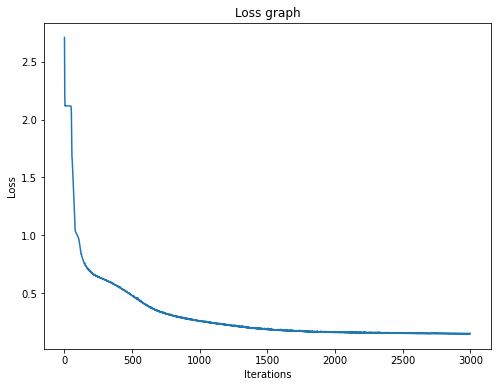

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model4.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()



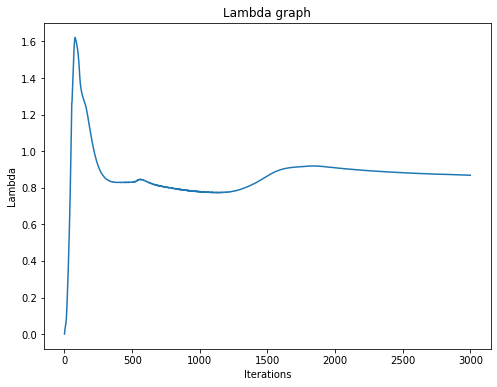

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model4.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [4]:
noise5 = 0.25       
u_train5 = u_train + noise5*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
q_5 = q_ + noise5*np.std(q_)*np.random.randn(q_.shape[0], q_.shape[1])
q_t_5= tf.convert_to_tensor(q_5,dtype=tf.float32)


In [5]:
model5 = PhysicsInformedNN3(X_u_train, u_train5, layers1, lb1, ub1 , q_t_5)
model5.train(30000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 6.508e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.39
It: 10, Loss: 5.388e+00, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.09
It: 20, Loss: 4.429e+00, Lambda_1: 0.018, Lambda_2: 1.000000, Time: 0.08
It: 30, Loss: 3.625e+00, Lambda_1: 0.029, Lambda_2: 1.000000, Time: 0.09
It: 40, Loss: 2.968e+00, Lambda_1: 0.039, Lambda_2: 1.000000, Time: 0.07
It: 50, Loss: 2.448e+00, Lambda_1: 0.048, Lambda_2: 1.000000, Time: 0.08
It: 60, Loss: 2.055e+00, Lambda_1: 0.059, Lambda_2: 1.000000, Time: 0.08
It: 70, Loss: 1.775e+00, Lambda_1: 0.073, Lambda_2: 1.000000, Time: 0.08
It: 80, Loss: 1.588e+00, Lambda_1: 0

It: 1060, Loss: 4.329e-01, Lambda_1: 2.305, Lambda_2: 1.000000, Time: 0.09
It: 1070, Loss: 4.279e-01, Lambda_1: 2.305, Lambda_2: 1.000000, Time: 0.09
It: 1080, Loss: 4.232e-01, Lambda_1: 2.305, Lambda_2: 1.000000, Time: 0.08
It: 1090, Loss: 4.187e-01, Lambda_1: 2.304, Lambda_2: 1.000000, Time: 0.08
It: 1100, Loss: 4.144e-01, Lambda_1: 2.302, Lambda_2: 1.000000, Time: 0.08
It: 1110, Loss: 4.102e-01, Lambda_1: 2.300, Lambda_2: 1.000000, Time: 0.08
It: 1120, Loss: 4.062e-01, Lambda_1: 2.298, Lambda_2: 1.000000, Time: 0.08
It: 1130, Loss: 4.023e-01, Lambda_1: 2.296, Lambda_2: 1.000000, Time: 0.08
It: 1140, Loss: 3.985e-01, Lambda_1: 2.293, Lambda_2: 1.000000, Time: 0.08
It: 1150, Loss: 3.949e-01, Lambda_1: 2.291, Lambda_2: 1.000000, Time: 0.08
It: 1160, Loss: 3.915e-01, Lambda_1: 2.288, Lambda_2: 1.000000, Time: 0.08
It: 1170, Loss: 3.883e-01, Lambda_1: 2.286, Lambda_2: 1.000000, Time: 0.08
It: 1180, Loss: 3.853e-01, Lambda_1: 2.284, Lambda_2: 1.000000, Time: 0.08
It: 1190, Loss: 3.825e-01

It: 2180, Loss: 2.146e-01, Lambda_1: 2.243, Lambda_2: 1.000000, Time: 0.08
It: 2190, Loss: 2.143e-01, Lambda_1: 2.241, Lambda_2: 1.000000, Time: 0.09
It: 2200, Loss: 2.141e-01, Lambda_1: 2.240, Lambda_2: 1.000000, Time: 0.09
It: 2210, Loss: 2.139e-01, Lambda_1: 2.238, Lambda_2: 1.000000, Time: 0.09
It: 2220, Loss: 2.137e-01, Lambda_1: 2.236, Lambda_2: 1.000000, Time: 0.08
It: 2230, Loss: 2.137e-01, Lambda_1: 2.234, Lambda_2: 1.000000, Time: 0.08
It: 2240, Loss: 2.133e-01, Lambda_1: 2.233, Lambda_2: 1.000000, Time: 0.08
It: 2250, Loss: 2.130e-01, Lambda_1: 2.231, Lambda_2: 1.000000, Time: 0.08
It: 2260, Loss: 2.128e-01, Lambda_1: 2.229, Lambda_2: 1.000000, Time: 0.08
It: 2270, Loss: 2.125e-01, Lambda_1: 2.227, Lambda_2: 1.000000, Time: 0.08
It: 2280, Loss: 2.123e-01, Lambda_1: 2.225, Lambda_2: 1.000000, Time: 0.08
It: 2290, Loss: 2.121e-01, Lambda_1: 2.223, Lambda_2: 1.000000, Time: 0.08
It: 2300, Loss: 2.119e-01, Lambda_1: 2.221, Lambda_2: 1.000000, Time: 0.08
It: 2310, Loss: 2.117e-01

It: 3280, Loss: 1.851e-01, Lambda_1: 2.101, Lambda_2: 1.000000, Time: 0.09
It: 3290, Loss: 1.853e-01, Lambda_1: 2.099, Lambda_2: 1.000000, Time: 0.10
It: 3300, Loss: 1.850e-01, Lambda_1: 2.097, Lambda_2: 1.000000, Time: 0.10
It: 3310, Loss: 1.849e-01, Lambda_1: 2.095, Lambda_2: 1.000000, Time: 0.09
It: 3320, Loss: 1.850e-01, Lambda_1: 2.093, Lambda_2: 1.000000, Time: 0.10
It: 3330, Loss: 1.853e-01, Lambda_1: 2.091, Lambda_2: 1.000000, Time: 0.10
It: 3340, Loss: 1.850e-01, Lambda_1: 2.089, Lambda_2: 1.000000, Time: 0.10
It: 3350, Loss: 1.846e-01, Lambda_1: 2.087, Lambda_2: 1.000000, Time: 0.10
It: 3360, Loss: 1.846e-01, Lambda_1: 2.085, Lambda_2: 1.000000, Time: 0.10
It: 3370, Loss: 1.847e-01, Lambda_1: 2.083, Lambda_2: 1.000000, Time: 0.10
It: 3380, Loss: 1.846e-01, Lambda_1: 2.081, Lambda_2: 1.000000, Time: 0.09
It: 3390, Loss: 1.845e-01, Lambda_1: 2.079, Lambda_2: 1.000000, Time: 0.09
It: 3400, Loss: 1.846e-01, Lambda_1: 2.077, Lambda_2: 1.000000, Time: 0.09
It: 3410, Loss: 1.844e-01

It: 4400, Loss: 1.796e-01, Lambda_1: 1.912, Lambda_2: 1.000000, Time: 0.09
It: 4410, Loss: 1.795e-01, Lambda_1: 1.911, Lambda_2: 1.000000, Time: 0.08
It: 4420, Loss: 1.795e-01, Lambda_1: 1.910, Lambda_2: 1.000000, Time: 0.08
It: 4430, Loss: 1.794e-01, Lambda_1: 1.910, Lambda_2: 1.000000, Time: 0.09
It: 4440, Loss: 1.794e-01, Lambda_1: 1.909, Lambda_2: 1.000000, Time: 0.08
It: 4450, Loss: 1.793e-01, Lambda_1: 1.908, Lambda_2: 1.000000, Time: 0.09
It: 4460, Loss: 1.793e-01, Lambda_1: 1.907, Lambda_2: 1.000000, Time: 0.09
It: 4470, Loss: 1.792e-01, Lambda_1: 1.906, Lambda_2: 1.000000, Time: 0.08
It: 4480, Loss: 1.792e-01, Lambda_1: 1.906, Lambda_2: 1.000000, Time: 0.08
It: 4490, Loss: 1.791e-01, Lambda_1: 1.905, Lambda_2: 1.000000, Time: 0.09
It: 4500, Loss: 1.791e-01, Lambda_1: 1.904, Lambda_2: 1.000000, Time: 0.08
It: 4510, Loss: 1.790e-01, Lambda_1: 1.903, Lambda_2: 1.000000, Time: 0.08
It: 4520, Loss: 1.790e-01, Lambda_1: 1.903, Lambda_2: 1.000000, Time: 0.10
It: 4530, Loss: 1.789e-01

It: 5510, Loss: 1.740e-01, Lambda_1: 1.897, Lambda_2: 1.000000, Time: 0.09
It: 5520, Loss: 1.740e-01, Lambda_1: 1.896, Lambda_2: 1.000000, Time: 0.08
It: 5530, Loss: 1.740e-01, Lambda_1: 1.896, Lambda_2: 1.000000, Time: 0.09
It: 5540, Loss: 1.739e-01, Lambda_1: 1.896, Lambda_2: 1.000000, Time: 0.09
It: 5550, Loss: 1.739e-01, Lambda_1: 1.896, Lambda_2: 1.000000, Time: 0.08
It: 5560, Loss: 1.739e-01, Lambda_1: 1.896, Lambda_2: 1.000000, Time: 0.08
It: 5570, Loss: 1.738e-01, Lambda_1: 1.895, Lambda_2: 1.000000, Time: 0.09
It: 5580, Loss: 1.738e-01, Lambda_1: 1.895, Lambda_2: 1.000000, Time: 0.08
It: 5590, Loss: 1.738e-01, Lambda_1: 1.895, Lambda_2: 1.000000, Time: 0.08
It: 5600, Loss: 1.737e-01, Lambda_1: 1.895, Lambda_2: 1.000000, Time: 0.09
It: 5610, Loss: 1.737e-01, Lambda_1: 1.895, Lambda_2: 1.000000, Time: 0.08
It: 5620, Loss: 1.737e-01, Lambda_1: 1.894, Lambda_2: 1.000000, Time: 0.09
It: 5630, Loss: 1.737e-01, Lambda_1: 1.894, Lambda_2: 1.000000, Time: 0.09
It: 5640, Loss: 1.736e-01

It: 6620, Loss: 1.712e-01, Lambda_1: 1.874, Lambda_2: 1.000000, Time: 0.09
It: 6630, Loss: 1.714e-01, Lambda_1: 1.874, Lambda_2: 1.000000, Time: 0.08
It: 6640, Loss: 1.708e-01, Lambda_1: 1.873, Lambda_2: 1.000000, Time: 0.08
It: 6650, Loss: 1.711e-01, Lambda_1: 1.873, Lambda_2: 1.000000, Time: 0.09
It: 6660, Loss: 1.712e-01, Lambda_1: 1.873, Lambda_2: 1.000000, Time: 0.08
It: 6670, Loss: 1.708e-01, Lambda_1: 1.873, Lambda_2: 1.000000, Time: 0.08
It: 6680, Loss: 1.710e-01, Lambda_1: 1.873, Lambda_2: 1.000000, Time: 0.09
It: 6690, Loss: 1.713e-01, Lambda_1: 1.872, Lambda_2: 1.000000, Time: 0.09
It: 6700, Loss: 1.707e-01, Lambda_1: 1.872, Lambda_2: 1.000000, Time: 0.08
It: 6710, Loss: 1.711e-01, Lambda_1: 1.872, Lambda_2: 1.000000, Time: 0.09
It: 6720, Loss: 1.710e-01, Lambda_1: 1.872, Lambda_2: 1.000000, Time: 0.08
It: 6730, Loss: 1.706e-01, Lambda_1: 1.871, Lambda_2: 1.000000, Time: 0.09
It: 6740, Loss: 1.708e-01, Lambda_1: 1.871, Lambda_2: 1.000000, Time: 0.09
It: 6750, Loss: 1.715e-01

It: 7730, Loss: 1.686e-01, Lambda_1: 1.844, Lambda_2: 1.000000, Time: 0.10
It: 7740, Loss: 1.685e-01, Lambda_1: 1.844, Lambda_2: 1.000000, Time: 0.11
It: 7750, Loss: 1.688e-01, Lambda_1: 1.844, Lambda_2: 1.000000, Time: 0.11
It: 7760, Loss: 1.699e-01, Lambda_1: 1.843, Lambda_2: 1.000000, Time: 0.10
It: 7770, Loss: 1.690e-01, Lambda_1: 1.842, Lambda_2: 1.000000, Time: 0.09
It: 7780, Loss: 1.685e-01, Lambda_1: 1.842, Lambda_2: 1.000000, Time: 0.10
It: 7790, Loss: 1.684e-01, Lambda_1: 1.842, Lambda_2: 1.000000, Time: 0.09
It: 7800, Loss: 1.684e-01, Lambda_1: 1.841, Lambda_2: 1.000000, Time: 0.09
It: 7810, Loss: 1.684e-01, Lambda_1: 1.841, Lambda_2: 1.000000, Time: 0.10
It: 7820, Loss: 1.684e-01, Lambda_1: 1.841, Lambda_2: 1.000000, Time: 0.11
It: 7830, Loss: 1.684e-01, Lambda_1: 1.841, Lambda_2: 1.000000, Time: 0.10
It: 7840, Loss: 1.684e-01, Lambda_1: 1.841, Lambda_2: 1.000000, Time: 0.11
It: 7850, Loss: 1.685e-01, Lambda_1: 1.840, Lambda_2: 1.000000, Time: 0.10
It: 7860, Loss: 1.683e-01

It: 8850, Loss: 1.633e-01, Lambda_1: 1.791, Lambda_2: 1.000000, Time: 0.10
It: 8860, Loss: 1.641e-01, Lambda_1: 1.791, Lambda_2: 1.000000, Time: 0.09
It: 8870, Loss: 1.633e-01, Lambda_1: 1.790, Lambda_2: 1.000000, Time: 0.09
It: 8880, Loss: 1.635e-01, Lambda_1: 1.790, Lambda_2: 1.000000, Time: 0.10
It: 8890, Loss: 1.633e-01, Lambda_1: 1.789, Lambda_2: 1.000000, Time: 0.09
It: 8900, Loss: 1.632e-01, Lambda_1: 1.789, Lambda_2: 1.000000, Time: 0.09
It: 8910, Loss: 1.632e-01, Lambda_1: 1.789, Lambda_2: 1.000000, Time: 0.09
It: 8920, Loss: 1.637e-01, Lambda_1: 1.788, Lambda_2: 1.000000, Time: 0.09
It: 8930, Loss: 1.631e-01, Lambda_1: 1.788, Lambda_2: 1.000000, Time: 0.09
It: 8940, Loss: 1.631e-01, Lambda_1: 1.788, Lambda_2: 1.000000, Time: 0.10
It: 8950, Loss: 1.632e-01, Lambda_1: 1.787, Lambda_2: 1.000000, Time: 0.10
It: 8960, Loss: 1.631e-01, Lambda_1: 1.787, Lambda_2: 1.000000, Time: 0.09
It: 8970, Loss: 1.631e-01, Lambda_1: 1.787, Lambda_2: 1.000000, Time: 0.10
It: 8980, Loss: 1.631e-01

It: 9950, Loss: 1.611e-01, Lambda_1: 1.756, Lambda_2: 1.000000, Time: 0.10
It: 9960, Loss: 1.612e-01, Lambda_1: 1.756, Lambda_2: 1.000000, Time: 0.09
It: 9970, Loss: 1.616e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.09
It: 9980, Loss: 1.610e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 9990, Loss: 1.610e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.09
It: 10000, Loss: 1.610e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 10010, Loss: 1.610e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 10020, Loss: 1.610e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.09
It: 10030, Loss: 1.610e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 10040, Loss: 1.609e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 10050, Loss: 1.609e-01, Lambda_1: 1.753, Lambda_2: 1.000000, Time: 0.10
It: 10060, Loss: 1.609e-01, Lambda_1: 1.753, Lambda_2: 1.000000, Time: 0.09
It: 10070, Loss: 1.618e-01, Lambda_1: 1.753, Lambda_2: 1.000000, Time: 0.10
It: 10080, Loss: 

It: 11030, Loss: 1.580e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11040, Loss: 1.580e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11050, Loss: 1.579e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11060, Loss: 1.580e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11070, Loss: 1.593e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.09
It: 11080, Loss: 1.583e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11090, Loss: 1.580e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.09
It: 11100, Loss: 1.579e-01, Lambda_1: 1.754, Lambda_2: 1.000000, Time: 0.10
It: 11110, Loss: 1.578e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 11120, Loss: 1.577e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 11130, Loss: 1.577e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 11140, Loss: 1.577e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 11150, Loss: 1.576e-01, Lambda_1: 1.755, Lambda_2: 1.000000, Time: 0.10
It: 11160, L

It: 12110, Loss: 1.552e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12120, Loss: 1.562e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.13
It: 12130, Loss: 1.552e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.16
It: 12140, Loss: 1.550e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.15
It: 12150, Loss: 1.549e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12160, Loss: 1.549e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.13
It: 12170, Loss: 1.551e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12180, Loss: 1.555e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12190, Loss: 1.550e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.13
It: 12200, Loss: 1.547e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12210, Loss: 1.547e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.15
It: 12220, Loss: 1.546e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.15
It: 12230, Loss: 1.546e-01, Lambda_1: 1.759, Lambda_2: 1.000000, Time: 0.14
It: 12240, L

It: 13190, Loss: 1.516e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.12
It: 13200, Loss: 1.515e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.11
It: 13210, Loss: 1.514e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.13
It: 13220, Loss: 1.514e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.11
It: 13230, Loss: 1.517e-01, Lambda_1: 1.751, Lambda_2: 1.000000, Time: 0.12
It: 13240, Loss: 1.521e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.11
It: 13250, Loss: 1.516e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.11
It: 13260, Loss: 1.513e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.11
It: 13270, Loss: 1.513e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.13
It: 13280, Loss: 1.513e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.12
It: 13290, Loss: 1.520e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.13
It: 13300, Loss: 1.511e-01, Lambda_1: 1.750, Lambda_2: 1.000000, Time: 0.13
It: 13310, Loss: 1.511e-01, Lambda_1: 1.749, Lambda_2: 1.000000, Time: 0.13
It: 13320, L

It: 14270, Loss: 1.479e-01, Lambda_1: 1.741, Lambda_2: 1.000000, Time: 0.12
It: 14280, Loss: 1.480e-01, Lambda_1: 1.741, Lambda_2: 1.000000, Time: 0.12
It: 14290, Loss: 1.482e-01, Lambda_1: 1.741, Lambda_2: 1.000000, Time: 0.12
It: 14300, Loss: 1.491e-01, Lambda_1: 1.741, Lambda_2: 1.000000, Time: 0.12
It: 14310, Loss: 1.482e-01, Lambda_1: 1.740, Lambda_2: 1.000000, Time: 0.12
It: 14320, Loss: 1.478e-01, Lambda_1: 1.740, Lambda_2: 1.000000, Time: 0.12
It: 14330, Loss: 1.478e-01, Lambda_1: 1.740, Lambda_2: 1.000000, Time: 0.12
It: 14340, Loss: 1.477e-01, Lambda_1: 1.740, Lambda_2: 1.000000, Time: 0.12
It: 14350, Loss: 1.482e-01, Lambda_1: 1.740, Lambda_2: 1.000000, Time: 0.12
It: 14360, Loss: 1.476e-01, Lambda_1: 1.739, Lambda_2: 1.000000, Time: 0.12
It: 14370, Loss: 1.481e-01, Lambda_1: 1.738, Lambda_2: 1.000000, Time: 0.12
It: 14380, Loss: 1.477e-01, Lambda_1: 1.738, Lambda_2: 1.000000, Time: 0.12
It: 14390, Loss: 1.475e-01, Lambda_1: 1.738, Lambda_2: 1.000000, Time: 0.12
It: 14400, L

It: 15350, Loss: 1.440e-01, Lambda_1: 1.703, Lambda_2: 1.000000, Time: 0.12
It: 15360, Loss: 1.434e-01, Lambda_1: 1.700, Lambda_2: 1.000000, Time: 0.12
It: 15370, Loss: 1.427e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.13
It: 15380, Loss: 1.424e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.13
It: 15390, Loss: 1.424e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.12
It: 15400, Loss: 1.422e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.12
It: 15410, Loss: 1.421e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.12
It: 15420, Loss: 1.421e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.12
It: 15430, Loss: 1.420e-01, Lambda_1: 1.699, Lambda_2: 1.000000, Time: 0.12
It: 15440, Loss: 1.489e-01, Lambda_1: 1.698, Lambda_2: 1.000000, Time: 0.12
It: 15450, Loss: 1.419e-01, Lambda_1: 1.695, Lambda_2: 1.000000, Time: 0.12
It: 15460, Loss: 1.430e-01, Lambda_1: 1.692, Lambda_2: 1.000000, Time: 0.13
It: 15470, Loss: 1.423e-01, Lambda_1: 1.692, Lambda_2: 1.000000, Time: 0.13
It: 15480, L

It: 16430, Loss: 1.347e-01, Lambda_1: 1.601, Lambda_2: 1.000000, Time: 0.13
It: 16440, Loss: 1.341e-01, Lambda_1: 1.600, Lambda_2: 1.000000, Time: 0.13
It: 16450, Loss: 1.337e-01, Lambda_1: 1.600, Lambda_2: 1.000000, Time: 0.14
It: 16460, Loss: 1.338e-01, Lambda_1: 1.599, Lambda_2: 1.000000, Time: 0.13
It: 16470, Loss: 1.341e-01, Lambda_1: 1.599, Lambda_2: 1.000000, Time: 0.13
It: 16480, Loss: 1.353e-01, Lambda_1: 1.598, Lambda_2: 1.000000, Time: 0.13
It: 16490, Loss: 1.341e-01, Lambda_1: 1.596, Lambda_2: 1.000000, Time: 0.13
It: 16500, Loss: 1.334e-01, Lambda_1: 1.595, Lambda_2: 1.000000, Time: 0.13
It: 16510, Loss: 1.333e-01, Lambda_1: 1.594, Lambda_2: 1.000000, Time: 0.13
It: 16520, Loss: 1.349e-01, Lambda_1: 1.593, Lambda_2: 1.000000, Time: 0.13
It: 16530, Loss: 1.331e-01, Lambda_1: 1.592, Lambda_2: 1.000000, Time: 0.13
It: 16540, Loss: 1.337e-01, Lambda_1: 1.590, Lambda_2: 1.000000, Time: 0.13
It: 16550, Loss: 1.329e-01, Lambda_1: 1.589, Lambda_2: 1.000000, Time: 0.13
It: 16560, L

It: 17510, Loss: 1.266e-01, Lambda_1: 1.484, Lambda_2: 1.000000, Time: 0.21
It: 17520, Loss: 1.256e-01, Lambda_1: 1.483, Lambda_2: 1.000000, Time: 0.20
It: 17530, Loss: 1.260e-01, Lambda_1: 1.481, Lambda_2: 1.000000, Time: 0.21
It: 17540, Loss: 1.252e-01, Lambda_1: 1.480, Lambda_2: 1.000000, Time: 0.20
It: 17550, Loss: 1.252e-01, Lambda_1: 1.480, Lambda_2: 1.000000, Time: 0.22
It: 17560, Loss: 1.264e-01, Lambda_1: 1.480, Lambda_2: 1.000000, Time: 0.25
It: 17570, Loss: 1.252e-01, Lambda_1: 1.478, Lambda_2: 1.000000, Time: 0.28
It: 17580, Loss: 1.256e-01, Lambda_1: 1.476, Lambda_2: 1.000000, Time: 0.24
It: 17590, Loss: 1.250e-01, Lambda_1: 1.475, Lambda_2: 1.000000, Time: 0.25
It: 17600, Loss: 1.253e-01, Lambda_1: 1.475, Lambda_2: 1.000000, Time: 0.21
It: 17610, Loss: 1.254e-01, Lambda_1: 1.474, Lambda_2: 1.000000, Time: 0.28
It: 17620, Loss: 1.250e-01, Lambda_1: 1.473, Lambda_2: 1.000000, Time: 0.21
It: 17630, Loss: 1.250e-01, Lambda_1: 1.472, Lambda_2: 1.000000, Time: 0.20
It: 17640, L

It: 18590, Loss: 1.206e-01, Lambda_1: 1.397, Lambda_2: 1.000000, Time: 0.16
It: 18600, Loss: 1.209e-01, Lambda_1: 1.397, Lambda_2: 1.000000, Time: 0.16
It: 18610, Loss: 1.221e-01, Lambda_1: 1.396, Lambda_2: 1.000000, Time: 0.17
It: 18620, Loss: 1.205e-01, Lambda_1: 1.395, Lambda_2: 1.000000, Time: 0.16
It: 18630, Loss: 1.210e-01, Lambda_1: 1.395, Lambda_2: 1.000000, Time: 0.18
It: 18640, Loss: 1.206e-01, Lambda_1: 1.394, Lambda_2: 1.000000, Time: 0.17
It: 18650, Loss: 1.205e-01, Lambda_1: 1.394, Lambda_2: 1.000000, Time: 0.16
It: 18660, Loss: 1.209e-01, Lambda_1: 1.394, Lambda_2: 1.000000, Time: 0.16
It: 18670, Loss: 1.228e-01, Lambda_1: 1.393, Lambda_2: 1.000000, Time: 0.18
It: 18680, Loss: 1.213e-01, Lambda_1: 1.391, Lambda_2: 1.000000, Time: 0.18
It: 18690, Loss: 1.206e-01, Lambda_1: 1.390, Lambda_2: 1.000000, Time: 0.18
It: 18700, Loss: 1.204e-01, Lambda_1: 1.390, Lambda_2: 1.000000, Time: 0.17
It: 18710, Loss: 1.203e-01, Lambda_1: 1.390, Lambda_2: 1.000000, Time: 0.17
It: 18720, L

It: 19670, Loss: 1.203e-01, Lambda_1: 1.349, Lambda_2: 1.000000, Time: 0.25
It: 19680, Loss: 1.189e-01, Lambda_1: 1.348, Lambda_2: 1.000000, Time: 0.25
It: 19690, Loss: 1.186e-01, Lambda_1: 1.347, Lambda_2: 1.000000, Time: 0.25
It: 19700, Loss: 1.186e-01, Lambda_1: 1.347, Lambda_2: 1.000000, Time: 0.24
It: 19710, Loss: 1.191e-01, Lambda_1: 1.348, Lambda_2: 1.000000, Time: 0.25
It: 19720, Loss: 1.194e-01, Lambda_1: 1.347, Lambda_2: 1.000000, Time: 0.24
It: 19730, Loss: 1.185e-01, Lambda_1: 1.346, Lambda_2: 1.000000, Time: 0.23
It: 19740, Loss: 1.189e-01, Lambda_1: 1.346, Lambda_2: 1.000000, Time: 0.23
It: 19750, Loss: 1.193e-01, Lambda_1: 1.346, Lambda_2: 1.000000, Time: 0.23
It: 19760, Loss: 1.184e-01, Lambda_1: 1.345, Lambda_2: 1.000000, Time: 0.23
It: 19770, Loss: 1.186e-01, Lambda_1: 1.345, Lambda_2: 1.000000, Time: 0.21
It: 19780, Loss: 1.202e-01, Lambda_1: 1.345, Lambda_2: 1.000000, Time: 0.21
It: 19790, Loss: 1.184e-01, Lambda_1: 1.344, Lambda_2: 1.000000, Time: 0.22
It: 19800, L

It: 20750, Loss: 1.171e-01, Lambda_1: 1.314, Lambda_2: 1.000000, Time: 0.25
It: 20760, Loss: 1.174e-01, Lambda_1: 1.314, Lambda_2: 1.000000, Time: 0.27
It: 20770, Loss: 1.176e-01, Lambda_1: 1.313, Lambda_2: 1.000000, Time: 0.25
It: 20780, Loss: 1.169e-01, Lambda_1: 1.312, Lambda_2: 1.000000, Time: 0.24
It: 20790, Loss: 1.167e-01, Lambda_1: 1.312, Lambda_2: 1.000000, Time: 0.26
It: 20800, Loss: 1.166e-01, Lambda_1: 1.312, Lambda_2: 1.000000, Time: 0.28
It: 20810, Loss: 1.166e-01, Lambda_1: 1.312, Lambda_2: 1.000000, Time: 0.26
It: 20820, Loss: 1.220e-01, Lambda_1: 1.311, Lambda_2: 1.000000, Time: 0.27
It: 20830, Loss: 1.191e-01, Lambda_1: 1.307, Lambda_2: 1.000000, Time: 0.34
It: 20840, Loss: 1.168e-01, Lambda_1: 1.304, Lambda_2: 1.000000, Time: 0.25
It: 20850, Loss: 1.162e-01, Lambda_1: 1.304, Lambda_2: 1.000000, Time: 0.26
It: 20860, Loss: 1.161e-01, Lambda_1: 1.304, Lambda_2: 1.000000, Time: 0.27
It: 20870, Loss: 1.160e-01, Lambda_1: 1.304, Lambda_2: 1.000000, Time: 0.28
It: 20880, L

It: 21830, Loss: 1.065e-01, Lambda_1: 1.076, Lambda_2: 1.000000, Time: 0.23
It: 21840, Loss: 1.064e-01, Lambda_1: 1.074, Lambda_2: 1.000000, Time: 0.25
It: 21850, Loss: 1.064e-01, Lambda_1: 1.071, Lambda_2: 1.000000, Time: 0.25
It: 21860, Loss: 1.096e-01, Lambda_1: 1.068, Lambda_2: 1.000000, Time: 0.28
It: 21870, Loss: 1.073e-01, Lambda_1: 1.062, Lambda_2: 1.000000, Time: 0.29
It: 21880, Loss: 1.067e-01, Lambda_1: 1.057, Lambda_2: 1.000000, Time: 0.33
It: 21890, Loss: 1.059e-01, Lambda_1: 1.056, Lambda_2: 1.000000, Time: 0.30
It: 21900, Loss: 1.059e-01, Lambda_1: 1.054, Lambda_2: 1.000000, Time: 0.34
It: 21910, Loss: 1.058e-01, Lambda_1: 1.053, Lambda_2: 1.000000, Time: 0.36
It: 21920, Loss: 1.057e-01, Lambda_1: 1.052, Lambda_2: 1.000000, Time: 0.28
It: 21930, Loss: 1.056e-01, Lambda_1: 1.050, Lambda_2: 1.000000, Time: 0.29
It: 21940, Loss: 1.055e-01, Lambda_1: 1.049, Lambda_2: 1.000000, Time: 0.31
It: 21950, Loss: 1.054e-01, Lambda_1: 1.047, Lambda_2: 1.000000, Time: 0.33
It: 21960, L

It: 22910, Loss: 9.891e-02, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.27
It: 22920, Loss: 9.887e-02, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.33
It: 22930, Loss: 9.883e-02, Lambda_1: 0.955, Lambda_2: 1.000000, Time: 0.25
It: 22940, Loss: 9.878e-02, Lambda_1: 0.955, Lambda_2: 1.000000, Time: 0.27
It: 22950, Loss: 9.875e-02, Lambda_1: 0.956, Lambda_2: 1.000000, Time: 0.26
It: 22960, Loss: 9.883e-02, Lambda_1: 0.956, Lambda_2: 1.000000, Time: 0.26
It: 22970, Loss: 1.059e-01, Lambda_1: 0.955, Lambda_2: 1.000000, Time: 0.24
It: 22980, Loss: 1.007e-01, Lambda_1: 0.949, Lambda_2: 1.000000, Time: 0.24
It: 22990, Loss: 9.932e-02, Lambda_1: 0.947, Lambda_2: 1.000000, Time: 0.23
It: 23000, Loss: 9.864e-02, Lambda_1: 0.948, Lambda_2: 1.000000, Time: 0.23
It: 23010, Loss: 9.868e-02, Lambda_1: 0.950, Lambda_2: 1.000000, Time: 0.23
It: 23020, Loss: 9.857e-02, Lambda_1: 0.951, Lambda_2: 1.000000, Time: 0.24
It: 23030, Loss: 9.851e-02, Lambda_1: 0.953, Lambda_2: 1.000000, Time: 0.24
It: 23040, L

It: 23990, Loss: 9.662e-02, Lambda_1: 0.937, Lambda_2: 1.000000, Time: 0.24
It: 24000, Loss: 9.657e-02, Lambda_1: 0.937, Lambda_2: 1.000000, Time: 0.22
It: 24010, Loss: 9.656e-02, Lambda_1: 0.938, Lambda_2: 1.000000, Time: 0.21
It: 24020, Loss: 9.658e-02, Lambda_1: 0.938, Lambda_2: 1.000000, Time: 0.23
It: 24030, Loss: 9.725e-02, Lambda_1: 0.938, Lambda_2: 1.000000, Time: 0.23
It: 24040, Loss: 9.921e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.24
It: 24050, Loss: 9.693e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.24
It: 24060, Loss: 9.648e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.24
It: 24070, Loss: 9.646e-02, Lambda_1: 0.933, Lambda_2: 1.000000, Time: 0.24
It: 24080, Loss: 9.643e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.23
It: 24090, Loss: 9.644e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.31
It: 24100, Loss: 9.640e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.24
It: 24110, Loss: 9.641e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.23
It: 24120, L

It: 25070, Loss: 9.493e-02, Lambda_1: 0.915, Lambda_2: 1.000000, Time: 0.32
It: 25080, Loss: 9.490e-02, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.23
It: 25090, Loss: 9.489e-02, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.22
It: 25100, Loss: 9.487e-02, Lambda_1: 0.916, Lambda_2: 1.000000, Time: 0.21
It: 25110, Loss: 9.485e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25120, Loss: 9.484e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25130, Loss: 9.483e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25140, Loss: 9.481e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25150, Loss: 9.480e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25160, Loss: 9.525e-02, Lambda_1: 0.917, Lambda_2: 1.000000, Time: 0.21
It: 25170, Loss: 1.006e-01, Lambda_1: 0.914, Lambda_2: 1.000000, Time: 0.21
It: 25180, Loss: 9.549e-02, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.23
It: 25190, Loss: 9.491e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.23
It: 25200, L

It: 26150, Loss: 9.351e-02, Lambda_1: 0.902, Lambda_2: 1.000000, Time: 0.19
It: 26160, Loss: 9.349e-02, Lambda_1: 0.902, Lambda_2: 1.000000, Time: 0.19
It: 26170, Loss: 9.348e-02, Lambda_1: 0.902, Lambda_2: 1.000000, Time: 0.19
It: 26180, Loss: 9.347e-02, Lambda_1: 0.902, Lambda_2: 1.000000, Time: 0.19
It: 26190, Loss: 9.436e-02, Lambda_1: 0.902, Lambda_2: 1.000000, Time: 0.19
It: 26200, Loss: 9.359e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.19
It: 26210, Loss: 9.507e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.19
It: 26220, Loss: 9.399e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.19
It: 26230, Loss: 9.367e-02, Lambda_1: 0.892, Lambda_2: 1.000000, Time: 0.19
It: 26240, Loss: 9.356e-02, Lambda_1: 0.894, Lambda_2: 1.000000, Time: 0.19
It: 26250, Loss: 9.344e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.19
It: 26260, Loss: 9.339e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.19
It: 26270, Loss: 9.338e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.19
It: 26280, L

It: 27230, Loss: 9.236e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.21
It: 27240, Loss: 9.239e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.19
It: 27250, Loss: 9.440e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.19
It: 27260, Loss: 9.246e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.19
It: 27270, Loss: 9.387e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.21
It: 27280, Loss: 9.236e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.19
It: 27290, Loss: 9.251e-02, Lambda_1: 0.884, Lambda_2: 1.000000, Time: 0.20
It: 27300, Loss: 9.239e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.19
It: 27310, Loss: 9.231e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.19
It: 27320, Loss: 9.229e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.20
It: 27330, Loss: 9.228e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 27340, Loss: 9.227e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 27350, Loss: 9.226e-02, Lambda_1: 0.889, Lambda_2: 1.000000, Time: 0.20
It: 27360, L

It: 28310, Loss: 9.193e-02, Lambda_1: 0.874, Lambda_2: 1.000000, Time: 0.20
It: 28320, Loss: 9.201e-02, Lambda_1: 0.874, Lambda_2: 1.000000, Time: 0.21
It: 28330, Loss: 9.160e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.21
It: 28340, Loss: 9.154e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.23
It: 28350, Loss: 9.154e-02, Lambda_1: 0.878, Lambda_2: 1.000000, Time: 0.21
It: 28360, Loss: 9.152e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.20
It: 28370, Loss: 9.150e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.20
It: 28380, Loss: 9.149e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.20
It: 28390, Loss: 9.149e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.21
It: 28400, Loss: 9.148e-02, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.19
It: 28410, Loss: 9.152e-02, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.19
It: 28420, Loss: 9.398e-02, Lambda_1: 0.881, Lambda_2: 1.000000, Time: 0.19
It: 28430, Loss: 9.171e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.19
It: 28440, L

It: 29390, Loss: 9.100e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.19
It: 29400, Loss: 9.096e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 29410, Loss: 9.110e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 29420, Loss: 9.438e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 29430, Loss: 9.164e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.19
It: 29440, Loss: 9.136e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.19
It: 29450, Loss: 9.108e-02, Lambda_1: 0.870, Lambda_2: 1.000000, Time: 0.19
It: 29460, Loss: 9.091e-02, Lambda_1: 0.871, Lambda_2: 1.000000, Time: 0.18
It: 29470, Loss: 9.094e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.19
It: 29480, Loss: 9.088e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.19
It: 29490, Loss: 9.088e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.19
It: 29500, Loss: 9.126e-02, Lambda_1: 0.873, Lambda_2: 1.000000, Time: 0.20
It: 29510, Loss: 9.728e-02, Lambda_1: 0.872, Lambda_2: 1.000000, Time: 0.19
It: 29520, L

In [6]:
np_loss_array_5=np.array(model5.loss_array)

with h5py.File('loss_array_5.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_loss_array_5)

np_lambda_array_5 = np.array(model5.lambda_array)

with h5py.File('lambda_array_5.hdf5', 'w') as f:
    dset = f.create_dataset("default", data = np_lambda_array_5)

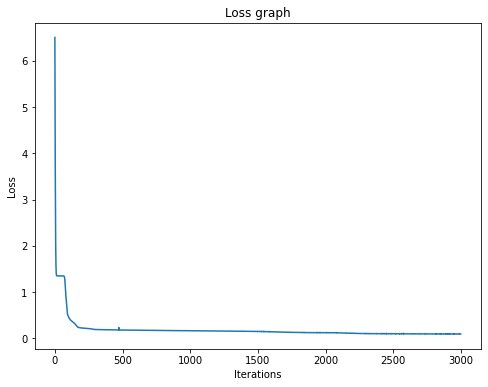

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model5.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()



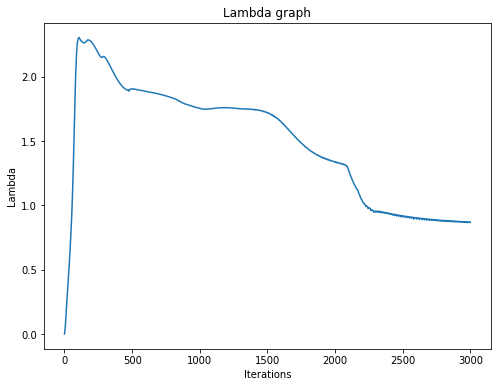

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model5.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()